In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [39]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = 5 * reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [40]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [35]:
# vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))  # change lr from 0.001 (default) to 0.0001

In [41]:
model_version_old = "0.0.1.0_reconstrweight1.5"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

Epoch 6400/6400
505/505  - 6s 11ms/step - loss: 619.6827 - reconstruction_loss: 411.9737 - kl_loss: 1.7221

In [42]:
model_version = "0.0.1.1_reconstrweight5"
os.system('mkdir ' + base_dir + '/weights_vae_' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights_vae_' + model_version + '/weights.{epoch:02d}-{loss:.2f}.h5', monitor='loss',
    verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq=505)


history_callback = vae.fit(x_train, epochs=50 * batch_size, batch_size=batch_size)


vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4432 - reconstruction_loss: 411.8461 - kl_loss: 2.2125
Epoch 2/6400
505/505 [==============================] - 5s 11ms/step - loss: 2061.1552 - reconstruction_loss: 411.7850 - kl_loss: 2.2304
Epoch 3/6400
505/505 [==============================] - 5s 11ms/step - loss: 2060.7781 - reconstruction_loss: 411.7085 - kl_loss: 2.2356
Epoch 4/6400
505/505 [==============================] - 5s 11ms/step - loss: 2061.1237 - reconstruction_loss: 411.7772 - kl_loss: 2.2378
Epoch 5/6400
505/505 [==============================] - 5s 11ms/step - loss: 2061.3608 - reconstruction_loss: 411.8240 - kl_loss: 2.2410
Epoch 6/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3090 - reconstruction_loss: 411.8134 - kl_loss: 2.2421
Epoch 7/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0515 - reconstruction_loss: 411.7614 - kl_loss: 2.2443
Epoch 8/6400
505/505 [===================

505/505 [==============================] - 6s 11ms/step - loss: 2060.9791 - reconstruction_loss: 411.7426 - kl_loss: 2.2660
Epoch 61/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8003 - reconstruction_loss: 411.7068 - kl_loss: 2.2663
Epoch 62/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0810 - reconstruction_loss: 411.7631 - kl_loss: 2.2656
Epoch 63/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9076 - reconstruction_loss: 411.7282 - kl_loss: 2.2665
Epoch 64/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.5819 - reconstruction_loss: 411.8632 - kl_loss: 2.2660
Epoch 65/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0130 - reconstruction_loss: 411.7494 - kl_loss: 2.2659
Epoch 66/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1683 - reconstruction_loss: 411.7806 - kl_loss: 2.2654
Epoch 67/6400
505/505 [=========================

505/505 [==============================] - 6s 11ms/step - loss: 2061.0378 - reconstruction_loss: 411.7526 - kl_loss: 2.2746
Epoch 120/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2012 - reconstruction_loss: 411.7850 - kl_loss: 2.2762
Epoch 121/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0038 - reconstruction_loss: 411.7460 - kl_loss: 2.2739
Epoch 122/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9445 - reconstruction_loss: 411.7339 - kl_loss: 2.2749
Epoch 123/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3005 - reconstruction_loss: 411.8054 - kl_loss: 2.2737
Epoch 124/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3499 - reconstruction_loss: 411.8149 - kl_loss: 2.2752
Epoch 125/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1161 - reconstruction_loss: 411.7677 - kl_loss: 2.2774
Epoch 126/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.9041 - reconstruction_loss: 411.7248 - kl_loss: 2.2799
Epoch 179/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8636 - reconstruction_loss: 411.7169 - kl_loss: 2.2793
Epoch 180/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2958 - reconstruction_loss: 411.8032 - kl_loss: 2.2796
Epoch 181/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2586 - reconstruction_loss: 411.7961 - kl_loss: 2.2781
Epoch 182/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7179 - reconstruction_loss: 411.6878 - kl_loss: 2.2787
Epoch 183/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0938 - reconstruction_loss: 411.7625 - kl_loss: 2.2813
Epoch 184/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0071 - reconstruction_loss: 411.7451 - kl_loss: 2.2815
Epoch 185/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.9870 - reconstruction_loss: 411.7408 - kl_loss: 2.2829
Epoch 238/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1533 - reconstruction_loss: 411.7740 - kl_loss: 2.2832
Epoch 239/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2195 - reconstruction_loss: 411.7872 - kl_loss: 2.2838
Epoch 240/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4439 - reconstruction_loss: 411.8320 - kl_loss: 2.2840
Epoch 241/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0803 - reconstruction_loss: 411.7590 - kl_loss: 2.2854
Epoch 242/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2926 - reconstruction_loss: 411.8020 - kl_loss: 2.2828
Epoch 243/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2369 - reconstruction_loss: 411.7906 - kl_loss: 2.2839
Epoch 244/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.2357 - reconstruction_loss: 411.7901 - kl_loss: 2.2852
Epoch 297/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.5889 - reconstruction_loss: 411.8608 - kl_loss: 2.2850
Epoch 298/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0286 - reconstruction_loss: 411.7484 - kl_loss: 2.2864
Epoch 299/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9592 - reconstruction_loss: 411.7350 - kl_loss: 2.2842
Epoch 300/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2357 - reconstruction_loss: 411.7899 - kl_loss: 2.2860
Epoch 301/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0456 - reconstruction_loss: 411.7518 - kl_loss: 2.2866
Epoch 302/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9598 - reconstruction_loss: 411.7347 - kl_loss: 2.2863
Epoch 303/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.7567 - reconstruction_loss: 411.6938 - kl_loss: 2.2880
Epoch 356/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1236 - reconstruction_loss: 411.7675 - kl_loss: 2.2861
Epoch 357/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9871 - reconstruction_loss: 411.7400 - kl_loss: 2.2871
Epoch 358/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9901 - reconstruction_loss: 411.7408 - kl_loss: 2.2863
Epoch 359/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0456 - reconstruction_loss: 411.7517 - kl_loss: 2.2872
Epoch 360/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1311 - reconstruction_loss: 411.7687 - kl_loss: 2.2874
Epoch 361/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0559 - reconstruction_loss: 411.7535 - kl_loss: 2.2884
Epoch 362/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.0632 - reconstruction_loss: 411.7549 - kl_loss: 2.2889
Epoch 415/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8495 - reconstruction_loss: 411.7122 - kl_loss: 2.2884
Epoch 416/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0374 - reconstruction_loss: 411.7496 - kl_loss: 2.2892
Epoch 417/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9944 - reconstruction_loss: 411.7408 - kl_loss: 2.2902
Epoch 418/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8435 - reconstruction_loss: 411.7110 - kl_loss: 2.2885
Epoch 419/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1635 - reconstruction_loss: 411.7750 - kl_loss: 2.2885
Epoch 420/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2985 - reconstruction_loss: 411.8021 - kl_loss: 2.2882
Epoch 421/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.3061 - reconstruction_loss: 411.8032 - kl_loss: 2.2899
Epoch 474/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1073 - reconstruction_loss: 411.7635 - kl_loss: 2.2897
Epoch 475/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0759 - reconstruction_loss: 411.7574 - kl_loss: 2.2891
Epoch 476/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9966 - reconstruction_loss: 411.7413 - kl_loss: 2.2901
Epoch 477/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9778 - reconstruction_loss: 411.7376 - kl_loss: 2.2897
Epoch 478/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9323 - reconstruction_loss: 411.7283 - kl_loss: 2.2907
Epoch 479/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2304 - reconstruction_loss: 411.7883 - kl_loss: 2.2890
Epoch 480/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.6974 - reconstruction_loss: 411.6812 - kl_loss: 2.2914
Epoch 533/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8440 - reconstruction_loss: 411.7106 - kl_loss: 2.2910
Epoch 534/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2573 - reconstruction_loss: 411.7931 - kl_loss: 2.2915
Epoch 535/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1708 - reconstruction_loss: 411.7765 - kl_loss: 2.2881
Epoch 536/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1364 - reconstruction_loss: 411.7690 - kl_loss: 2.2914
Epoch 537/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1319 - reconstruction_loss: 411.7682 - kl_loss: 2.2910
Epoch 538/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3786 - reconstruction_loss: 411.8174 - kl_loss: 2.2915
Epoch 539/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.3313 - reconstruction_loss: 411.8080 - kl_loss: 2.2911
Epoch 592/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3795 - reconstruction_loss: 411.8178 - kl_loss: 2.2905
Epoch 593/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0774 - reconstruction_loss: 411.7574 - kl_loss: 2.2904
Epoch 594/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4222 - reconstruction_loss: 411.8260 - kl_loss: 2.2923
Epoch 595/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8052 - reconstruction_loss: 411.7028 - kl_loss: 2.2915
Epoch 596/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9277 - reconstruction_loss: 411.7269 - kl_loss: 2.2930
Epoch 597/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4042 - reconstruction_loss: 411.8226 - kl_loss: 2.2911
Epoch 598/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.2282 - reconstruction_loss: 411.7871 - kl_loss: 2.2925
Epoch 651/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2131 - reconstruction_loss: 411.7839 - kl_loss: 2.2937
Epoch 652/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0326 - reconstruction_loss: 411.7479 - kl_loss: 2.2933
Epoch 653/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9258 - reconstruction_loss: 411.7263 - kl_loss: 2.2941
Epoch 654/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8899 - reconstruction_loss: 411.7192 - kl_loss: 2.2940
Epoch 655/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8131 - reconstruction_loss: 411.7038 - kl_loss: 2.2941
Epoch 656/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0787 - reconstruction_loss: 411.7578 - kl_loss: 2.2899
Epoch 657/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.0830 - reconstruction_loss: 411.7577 - kl_loss: 2.2943
Epoch 710/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0816 - reconstruction_loss: 411.7579 - kl_loss: 2.2923
Epoch 711/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8921 - reconstruction_loss: 411.7197 - kl_loss: 2.2937
Epoch 712/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9823 - reconstruction_loss: 411.7380 - kl_loss: 2.2921
Epoch 713/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1863 - reconstruction_loss: 411.7783 - kl_loss: 2.2946
Epoch 714/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0430 - reconstruction_loss: 411.7500 - kl_loss: 2.2929
Epoch 715/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0439 - reconstruction_loss: 411.7499 - kl_loss: 2.2944
Epoch 716/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.9554 - reconstruction_loss: 411.7324 - kl_loss: 2.2935
Epoch 769/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2242 - reconstruction_loss: 411.7859 - kl_loss: 2.2945
Epoch 770/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0963 - reconstruction_loss: 411.7605 - kl_loss: 2.2938
Epoch 771/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0726 - reconstruction_loss: 411.7558 - kl_loss: 2.2936
Epoch 772/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9540 - reconstruction_loss: 411.7319 - kl_loss: 2.2946
Epoch 773/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3381 - reconstruction_loss: 411.8085 - kl_loss: 2.2954
Epoch 774/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9810 - reconstruction_loss: 411.7372 - kl_loss: 2.2950
Epoch 775/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.9821 - reconstruction_loss: 411.7377 - kl_loss: 2.2937
Epoch 828/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8528 - reconstruction_loss: 411.7119 - kl_loss: 2.2936
Epoch 829/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2995 - reconstruction_loss: 411.8011 - kl_loss: 2.2940
Epoch 830/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9838 - reconstruction_loss: 411.7381 - kl_loss: 2.2935
Epoch 831/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2833 - reconstruction_loss: 411.7978 - kl_loss: 2.2945
Epoch 832/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2132 - reconstruction_loss: 411.7839 - kl_loss: 2.2940
Epoch 833/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0585 - reconstruction_loss: 411.7529 - kl_loss: 2.2942
Epoch 834/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2060.9456 - reconstruction_loss: 411.7300 - kl_loss: 2.2956
Epoch 887/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8602 - reconstruction_loss: 411.7131 - kl_loss: 2.2948
Epoch 888/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8800 - reconstruction_loss: 411.7170 - kl_loss: 2.2951
Epoch 889/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3458 - reconstruction_loss: 411.8103 - kl_loss: 2.2943
Epoch 890/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1565 - reconstruction_loss: 411.7725 - kl_loss: 2.2940
Epoch 891/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1626 - reconstruction_loss: 411.7731 - kl_loss: 2.2969
Epoch 892/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3395 - reconstruction_loss: 411.8091 - kl_loss: 2.2942
Epoch 893/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.0951 - reconstruction_loss: 411.7597 - kl_loss: 2.2966
Epoch 946/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9425 - reconstruction_loss: 411.7291 - kl_loss: 2.2969
Epoch 947/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0810 - reconstruction_loss: 411.7568 - kl_loss: 2.2972
Epoch 948/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1886 - reconstruction_loss: 411.7784 - kl_loss: 2.2965
Epoch 949/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9818 - reconstruction_loss: 411.7373 - kl_loss: 2.2955
Epoch 950/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9486 - reconstruction_loss: 411.7306 - kl_loss: 2.2958
Epoch 951/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9569 - reconstruction_loss: 411.7321 - kl_loss: 2.2963
Epoch 952/6400
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 2061.1336 - reconstruction_loss: 411.7673 - kl_loss: 2.2972
Epoch 1005/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2145 - reconstruction_loss: 411.7833 - kl_loss: 2.2977
Epoch 1006/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3488 - reconstruction_loss: 411.8104 - kl_loss: 2.2969
Epoch 1007/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9382 - reconstruction_loss: 411.7281 - kl_loss: 2.2975
Epoch 1008/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2443 - reconstruction_loss: 411.7896 - kl_loss: 2.2963
Epoch 1009/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0578 - reconstruction_loss: 411.7525 - kl_loss: 2.2954
Epoch 1010/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9529 - reconstruction_loss: 411.7311 - kl_loss: 2.2973
Epoch 1011/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9797 - reconstruction_loss: 411.7368 - kl_loss: 2.2958
Epoch 1063/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8396 - reconstruction_loss: 411.7082 - kl_loss: 2.2987
Epoch 1064/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0502 - reconstruction_loss: 411.7509 - kl_loss: 2.2957
Epoch 1065/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2930 - reconstruction_loss: 411.7991 - kl_loss: 2.2973
Epoch 1066/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2541 - reconstruction_loss: 411.7915 - kl_loss: 2.2966
Epoch 1067/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8251 - reconstruction_loss: 411.7054 - kl_loss: 2.2980
Epoch 1068/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0385 - reconstruction_loss: 411.7483 - kl_loss: 2.2969
Epoch 1069/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0646 - reconstruction_loss: 411.7533 - kl_loss: 2.2980
Epoch 1121/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9413 - reconstruction_loss: 411.7288 - kl_loss: 2.2971
Epoch 1122/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0850 - reconstruction_loss: 411.7575 - kl_loss: 2.2976
Epoch 1123/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8204 - reconstruction_loss: 411.7046 - kl_loss: 2.2976
Epoch 1124/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8992 - reconstruction_loss: 411.7203 - kl_loss: 2.2979
Epoch 1125/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2267 - reconstruction_loss: 411.7860 - kl_loss: 2.2968
Epoch 1126/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0170 - reconstruction_loss: 411.7439 - kl_loss: 2.2975
Epoch 1127/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1014 - reconstruction_loss: 411.7605 - kl_loss: 2.2990
Epoch 1179/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0692 - reconstruction_loss: 411.7540 - kl_loss: 2.2990
Epoch 1180/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0058 - reconstruction_loss: 411.7417 - kl_loss: 2.2973
Epoch 1181/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1242 - reconstruction_loss: 411.7657 - kl_loss: 2.2959
Epoch 1182/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1029 - reconstruction_loss: 411.7610 - kl_loss: 2.2981
Epoch 1183/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0445 - reconstruction_loss: 411.7494 - kl_loss: 2.2977
Epoch 1184/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0680 - reconstruction_loss: 411.7540 - kl_loss: 2.2982
Epoch 1185/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1741 - reconstruction_loss: 411.7751 - kl_loss: 2.2985
Epoch 1237/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1311 - reconstruction_loss: 411.7663 - kl_loss: 2.2997
Epoch 1238/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3013 - reconstruction_loss: 411.8004 - kl_loss: 2.2990
Epoch 1239/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8099 - reconstruction_loss: 411.7024 - kl_loss: 2.2980
Epoch 1240/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3202 - reconstruction_loss: 411.8045 - kl_loss: 2.2979
Epoch 1241/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8222 - reconstruction_loss: 411.7048 - kl_loss: 2.2980
Epoch 1242/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9825 - reconstruction_loss: 411.7367 - kl_loss: 2.2989
Epoch 1243/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0317 - reconstruction_loss: 411.7469 - kl_loss: 2.2973
Epoch 1295/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9327 - reconstruction_loss: 411.7268 - kl_loss: 2.2990
Epoch 1296/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3659 - reconstruction_loss: 411.8134 - kl_loss: 2.2990
Epoch 1297/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9644 - reconstruction_loss: 411.7332 - kl_loss: 2.2982
Epoch 1298/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1389 - reconstruction_loss: 411.7680 - kl_loss: 2.2989
Epoch 1299/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9860 - reconstruction_loss: 411.7373 - kl_loss: 2.2994
Epoch 1300/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3594 - reconstruction_loss: 411.8119 - kl_loss: 2.3000
Epoch 1301/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9211 - reconstruction_loss: 411.7243 - kl_loss: 2.2997
Epoch 1353/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0633 - reconstruction_loss: 411.7533 - kl_loss: 2.2969
Epoch 1354/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0194 - reconstruction_loss: 411.7443 - kl_loss: 2.2979
Epoch 1355/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0720 - reconstruction_loss: 411.7543 - kl_loss: 2.3003
Epoch 1356/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9757 - reconstruction_loss: 411.7352 - kl_loss: 2.2996
Epoch 1357/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3588 - reconstruction_loss: 411.8120 - kl_loss: 2.2989
Epoch 1358/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0346 - reconstruction_loss: 411.7472 - kl_loss: 2.2986
Epoch 1359/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1631 - reconstruction_loss: 411.7728 - kl_loss: 2.2991
Epoch 1411/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9117 - reconstruction_loss: 411.7224 - kl_loss: 2.2998
Epoch 1412/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0900 - reconstruction_loss: 411.7582 - kl_loss: 2.2992
Epoch 1413/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1389 - reconstruction_loss: 411.7679 - kl_loss: 2.2994
Epoch 1414/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0567 - reconstruction_loss: 411.7514 - kl_loss: 2.2998
Epoch 1415/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9964 - reconstruction_loss: 411.7394 - kl_loss: 2.2994
Epoch 1416/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3262 - reconstruction_loss: 411.8051 - kl_loss: 2.3009
Epoch 1417/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1717 - reconstruction_loss: 411.7745 - kl_loss: 2.2993
Epoch 1469/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1711 - reconstruction_loss: 411.7743 - kl_loss: 2.2997
Epoch 1470/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0198 - reconstruction_loss: 411.7442 - kl_loss: 2.2989
Epoch 1471/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8756 - reconstruction_loss: 411.7151 - kl_loss: 2.3001
Epoch 1472/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1913 - reconstruction_loss: 411.7784 - kl_loss: 2.2992
Epoch 1473/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0133 - reconstruction_loss: 411.7426 - kl_loss: 2.3003
Epoch 1474/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0968 - reconstruction_loss: 411.7592 - kl_loss: 2.3006
Epoch 1475/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0639 - reconstruction_loss: 411.7526 - kl_loss: 2.3010
Epoch 1527/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2244 - reconstruction_loss: 411.7850 - kl_loss: 2.2996
Epoch 1528/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7965 - reconstruction_loss: 411.6989 - kl_loss: 2.3018
Epoch 1529/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8428 - reconstruction_loss: 411.7084 - kl_loss: 2.3008
Epoch 1530/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2416 - reconstruction_loss: 411.7886 - kl_loss: 2.2987
Epoch 1531/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1657 - reconstruction_loss: 411.7732 - kl_loss: 2.2999
Epoch 1532/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2155 - reconstruction_loss: 411.7831 - kl_loss: 2.3001
Epoch 1533/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9763 - reconstruction_loss: 411.7350 - kl_loss: 2.3012
Epoch 1585/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0705 - reconstruction_loss: 411.7538 - kl_loss: 2.3017
Epoch 1586/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0317 - reconstruction_loss: 411.7463 - kl_loss: 2.3001
Epoch 1587/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0954 - reconstruction_loss: 411.7587 - kl_loss: 2.3020
Epoch 1588/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1754 - reconstruction_loss: 411.7749 - kl_loss: 2.3010
Epoch 1589/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1042 - reconstruction_loss: 411.7605 - kl_loss: 2.3017
Epoch 1590/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1501 - reconstruction_loss: 411.7697 - kl_loss: 2.3015
Epoch 1591/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1932 - reconstruction_loss: 411.7785 - kl_loss: 2.3008
Epoch 1643/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2779 - reconstruction_loss: 411.7952 - kl_loss: 2.3017
Epoch 1644/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1835 - reconstruction_loss: 411.7767 - kl_loss: 2.3000
Epoch 1645/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1841 - reconstruction_loss: 411.7766 - kl_loss: 2.3012
Epoch 1646/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9834 - reconstruction_loss: 411.7365 - kl_loss: 2.3010
Epoch 1647/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3578 - reconstruction_loss: 411.8114 - kl_loss: 2.3008
Epoch 1648/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9446 - reconstruction_loss: 411.7286 - kl_loss: 2.3018
Epoch 1649/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2927 - reconstruction_loss: 411.7980 - kl_loss: 2.3026
Epoch 1701/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7375 - reconstruction_loss: 411.6873 - kl_loss: 2.3008
Epoch 1702/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9484 - reconstruction_loss: 411.7292 - kl_loss: 2.3024
Epoch 1703/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0149 - reconstruction_loss: 411.7427 - kl_loss: 2.3013
Epoch 1704/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0465 - reconstruction_loss: 411.7488 - kl_loss: 2.3025
Epoch 1705/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9948 - reconstruction_loss: 411.7384 - kl_loss: 2.3029
Epoch 1706/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0899 - reconstruction_loss: 411.7576 - kl_loss: 2.3017
Epoch 1707/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0560 - reconstruction_loss: 411.7510 - kl_loss: 2.3011
Epoch 1759/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0732 - reconstruction_loss: 411.7541 - kl_loss: 2.3028
Epoch 1760/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1341 - reconstruction_loss: 411.7663 - kl_loss: 2.3024
Epoch 1761/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0818 - reconstruction_loss: 411.7560 - kl_loss: 2.3016
Epoch 1762/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2134 - reconstruction_loss: 411.7821 - kl_loss: 2.3029
Epoch 1763/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8131 - reconstruction_loss: 411.7024 - kl_loss: 2.3012
Epoch 1764/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9925 - reconstruction_loss: 411.7384 - kl_loss: 2.3007
Epoch 1765/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2246 - reconstruction_loss: 411.7843 - kl_loss: 2.3030
Epoch 1817/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8056 - reconstruction_loss: 411.7005 - kl_loss: 2.3031
Epoch 1818/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0002 - reconstruction_loss: 411.7394 - kl_loss: 2.3032
Epoch 1819/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2453 - reconstruction_loss: 411.7886 - kl_loss: 2.3023
Epoch 1820/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9197 - reconstruction_loss: 411.7237 - kl_loss: 2.3009
Epoch 1821/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3521 - reconstruction_loss: 411.8101 - kl_loss: 2.3017
Epoch 1822/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1777 - reconstruction_loss: 411.7752 - kl_loss: 2.3018
Epoch 1823/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.4525 - reconstruction_loss: 411.8300 - kl_loss: 2.3026
Epoch 1875/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1883 - reconstruction_loss: 411.7772 - kl_loss: 2.3023
Epoch 1876/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2412 - reconstruction_loss: 411.7878 - kl_loss: 2.3022
Epoch 1877/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0374 - reconstruction_loss: 411.7463 - kl_loss: 2.3060
Epoch 1878/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1831 - reconstruction_loss: 411.7762 - kl_loss: 2.3023
Epoch 1879/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1554 - reconstruction_loss: 411.7706 - kl_loss: 2.3026
Epoch 1880/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8794 - reconstruction_loss: 411.7151 - kl_loss: 2.3040
Epoch 1881/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9585 - reconstruction_loss: 411.7310 - kl_loss: 2.3037
Epoch 1933/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9555 - reconstruction_loss: 411.7302 - kl_loss: 2.3044
Epoch 1934/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2111 - reconstruction_loss: 411.7820 - kl_loss: 2.3012
Epoch 1935/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1701 - reconstruction_loss: 411.7736 - kl_loss: 2.3019
Epoch 1936/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9524 - reconstruction_loss: 411.7298 - kl_loss: 2.3032
Epoch 1937/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9837 - reconstruction_loss: 411.7361 - kl_loss: 2.3029
Epoch 1938/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2271 - reconstruction_loss: 411.7848 - kl_loss: 2.3029
Epoch 1939/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9328 - reconstruction_loss: 411.7260 - kl_loss: 2.3028
Epoch 1991/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.5816 - reconstruction_loss: 411.6554 - kl_loss: 2.3046
Epoch 1992/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0584 - reconstruction_loss: 411.7508 - kl_loss: 2.3047
Epoch 1993/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2710 - reconstruction_loss: 411.7936 - kl_loss: 2.3030
Epoch 1994/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0130 - reconstruction_loss: 411.7419 - kl_loss: 2.3034
Epoch 1995/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2376 - reconstruction_loss: 411.7867 - kl_loss: 2.3040
Epoch 1996/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8294 - reconstruction_loss: 411.7049 - kl_loss: 2.3049
Epoch 1997/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1236 - reconstruction_loss: 411.7639 - kl_loss: 2.3042
Epoch 2049/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2139 - reconstruction_loss: 411.7818 - kl_loss: 2.3047
Epoch 2050/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0712 - reconstruction_loss: 411.7534 - kl_loss: 2.3041
Epoch 2051/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2053 - reconstruction_loss: 411.7804 - kl_loss: 2.3032
Epoch 2052/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3427 - reconstruction_loss: 411.8079 - kl_loss: 2.3035
Epoch 2053/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1307 - reconstruction_loss: 411.7654 - kl_loss: 2.3038
Epoch 2054/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8111 - reconstruction_loss: 411.7017 - kl_loss: 2.3026
Epoch 2055/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1897 - reconstruction_loss: 411.7773 - kl_loss: 2.3034
Epoch 2107/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8762 - reconstruction_loss: 411.7143 - kl_loss: 2.3047
Epoch 2108/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9860 - reconstruction_loss: 411.7365 - kl_loss: 2.3037
Epoch 2109/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1552 - reconstruction_loss: 411.7702 - kl_loss: 2.3042
Epoch 2110/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9785 - reconstruction_loss: 411.7351 - kl_loss: 2.3030
Epoch 2111/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0581 - reconstruction_loss: 411.7509 - kl_loss: 2.3034
Epoch 2112/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9703 - reconstruction_loss: 411.7331 - kl_loss: 2.3047
Epoch 2113/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1018 - reconstruction_loss: 411.7594 - kl_loss: 2.3046
Epoch 2165/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1097 - reconstruction_loss: 411.7609 - kl_loss: 2.3050
Epoch 2166/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4053 - reconstruction_loss: 411.8207 - kl_loss: 2.3019
Epoch 2167/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9345 - reconstruction_loss: 411.7260 - kl_loss: 2.3045
Epoch 2168/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8417 - reconstruction_loss: 411.7074 - kl_loss: 2.3048
Epoch 2169/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9981 - reconstruction_loss: 411.7390 - kl_loss: 2.3031
Epoch 2170/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8989 - reconstruction_loss: 411.7187 - kl_loss: 2.3055
Epoch 2171/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0950 - reconstruction_loss: 411.7581 - kl_loss: 2.3046
Epoch 2223/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0956 - reconstruction_loss: 411.7581 - kl_loss: 2.3053
Epoch 2224/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9807 - reconstruction_loss: 411.7348 - kl_loss: 2.3068
Epoch 2225/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0123 - reconstruction_loss: 411.7415 - kl_loss: 2.3049
Epoch 2226/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2208 - reconstruction_loss: 411.7833 - kl_loss: 2.3045
Epoch 2227/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0823 - reconstruction_loss: 411.7554 - kl_loss: 2.3052
Epoch 2228/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1710 - reconstruction_loss: 411.7735 - kl_loss: 2.3036
Epoch 2229/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1911 - reconstruction_loss: 411.7776 - kl_loss: 2.3030
Epoch 2281/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9388 - reconstruction_loss: 411.7267 - kl_loss: 2.3051
Epoch 2282/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0180 - reconstruction_loss: 411.7429 - kl_loss: 2.3036
Epoch 2283/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8660 - reconstruction_loss: 411.7123 - kl_loss: 2.3045
Epoch 2284/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1935 - reconstruction_loss: 411.7778 - kl_loss: 2.3042
Epoch 2285/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9841 - reconstruction_loss: 411.7358 - kl_loss: 2.3048
Epoch 2286/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1023 - reconstruction_loss: 411.7599 - kl_loss: 2.3029
Epoch 2287/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.6990 - reconstruction_loss: 411.6787 - kl_loss: 2.3053
Epoch 2339/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2887 - reconstruction_loss: 411.7970 - kl_loss: 2.3039
Epoch 2340/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0372 - reconstruction_loss: 411.7467 - kl_loss: 2.3038
Epoch 2341/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9524 - reconstruction_loss: 411.7297 - kl_loss: 2.3041
Epoch 2342/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1156 - reconstruction_loss: 411.7619 - kl_loss: 2.3061
Epoch 2343/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0935 - reconstruction_loss: 411.7578 - kl_loss: 2.3045
Epoch 2344/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2267 - reconstruction_loss: 411.7843 - kl_loss: 2.3053
Epoch 2345/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1454 - reconstruction_loss: 411.7679 - kl_loss: 2.3057
Epoch 2397/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2928 - reconstruction_loss: 411.7975 - kl_loss: 2.3051
Epoch 2398/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2378 - reconstruction_loss: 411.7861 - kl_loss: 2.3073
Epoch 2399/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8492 - reconstruction_loss: 411.7087 - kl_loss: 2.3057
Epoch 2400/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9736 - reconstruction_loss: 411.7336 - kl_loss: 2.3057
Epoch 2401/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0904 - reconstruction_loss: 411.7570 - kl_loss: 2.3053
Epoch 2402/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9652 - reconstruction_loss: 411.7321 - kl_loss: 2.3047
Epoch 2403/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2150 - reconstruction_loss: 411.7818 - kl_loss: 2.3059
Epoch 2455/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.6188 - reconstruction_loss: 411.6626 - kl_loss: 2.3060
Epoch 2456/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3302 - reconstruction_loss: 411.8049 - kl_loss: 2.3056
Epoch 2457/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1853 - reconstruction_loss: 411.7760 - kl_loss: 2.3052
Epoch 2458/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1325 - reconstruction_loss: 411.7652 - kl_loss: 2.3065
Epoch 2459/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8852 - reconstruction_loss: 411.7160 - kl_loss: 2.3051
Epoch 2460/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2048 - reconstruction_loss: 411.7798 - kl_loss: 2.3059
Epoch 2461/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2594 - reconstruction_loss: 411.7909 - kl_loss: 2.3048
Epoch 2513/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1500 - reconstruction_loss: 411.7688 - kl_loss: 2.3060
Epoch 2514/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8070 - reconstruction_loss: 411.7001 - kl_loss: 2.3065
Epoch 2515/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9013 - reconstruction_loss: 411.7192 - kl_loss: 2.3052
Epoch 2516/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9264 - reconstruction_loss: 411.7239 - kl_loss: 2.3072
Epoch 2517/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0699 - reconstruction_loss: 411.7525 - kl_loss: 2.3076
Epoch 2518/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3412 - reconstruction_loss: 411.8072 - kl_loss: 2.3055
Epoch 2519/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0412 - reconstruction_loss: 411.7469 - kl_loss: 2.3065
Epoch 2571/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1990 - reconstruction_loss: 411.7788 - kl_loss: 2.3048
Epoch 2572/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0710 - reconstruction_loss: 411.7529 - kl_loss: 2.3067
Epoch 2573/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0946 - reconstruction_loss: 411.7577 - kl_loss: 2.3061
Epoch 2574/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0579 - reconstruction_loss: 411.7504 - kl_loss: 2.3060
Epoch 2575/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9861 - reconstruction_loss: 411.7359 - kl_loss: 2.3064
Epoch 2576/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0563 - reconstruction_loss: 411.7503 - kl_loss: 2.3050
Epoch 2577/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.4532 - reconstruction_loss: 411.8290 - kl_loss: 2.3079
Epoch 2629/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0637 - reconstruction_loss: 411.7514 - kl_loss: 2.3069
Epoch 2630/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1861 - reconstruction_loss: 411.7758 - kl_loss: 2.3069
Epoch 2631/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8674 - reconstruction_loss: 411.7124 - kl_loss: 2.3052
Epoch 2632/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1628 - reconstruction_loss: 411.7711 - kl_loss: 2.3072
Epoch 2633/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1092 - reconstruction_loss: 411.7604 - kl_loss: 2.3070
Epoch 2634/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1257 - reconstruction_loss: 411.7638 - kl_loss: 2.3068
Epoch 2635/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1860 - reconstruction_loss: 411.7758 - kl_loss: 2.3072
Epoch 2687/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2723 - reconstruction_loss: 411.7931 - kl_loss: 2.3067
Epoch 2688/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8578 - reconstruction_loss: 411.7100 - kl_loss: 2.3080
Epoch 2689/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0944 - reconstruction_loss: 411.7576 - kl_loss: 2.3065
Epoch 2690/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8787 - reconstruction_loss: 411.7144 - kl_loss: 2.3068
Epoch 2691/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0418 - reconstruction_loss: 411.7470 - kl_loss: 2.3070
Epoch 2692/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0202 - reconstruction_loss: 411.7428 - kl_loss: 2.3063
Epoch 2693/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0985 - reconstruction_loss: 411.7582 - kl_loss: 2.3074
Epoch 2745/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1184 - reconstruction_loss: 411.7622 - kl_loss: 2.3073
Epoch 2746/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0395 - reconstruction_loss: 411.7465 - kl_loss: 2.3068
Epoch 2747/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9128 - reconstruction_loss: 411.7213 - kl_loss: 2.3065
Epoch 2748/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1984 - reconstruction_loss: 411.7782 - kl_loss: 2.3076
Epoch 2749/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9177 - reconstruction_loss: 411.7219 - kl_loss: 2.3080
Epoch 2750/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1935 - reconstruction_loss: 411.7771 - kl_loss: 2.3081
Epoch 2751/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0500 - reconstruction_loss: 411.7484 - kl_loss: 2.3079
Epoch 2803/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8644 - reconstruction_loss: 411.7118 - kl_loss: 2.3055
Epoch 2804/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8802 - reconstruction_loss: 411.7143 - kl_loss: 2.3085
Epoch 2805/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7598 - reconstruction_loss: 411.6907 - kl_loss: 2.3061
Epoch 2806/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1749 - reconstruction_loss: 411.7736 - kl_loss: 2.3066
Epoch 2807/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1824 - reconstruction_loss: 411.7754 - kl_loss: 2.3056
Epoch 2808/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9100 - reconstruction_loss: 411.7207 - kl_loss: 2.3067
Epoch 2809/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2997 - reconstruction_loss: 411.7989 - kl_loss: 2.3053
Epoch 2861/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3666 - reconstruction_loss: 411.8116 - kl_loss: 2.3084
Epoch 2862/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1381 - reconstruction_loss: 411.7660 - kl_loss: 2.3083
Epoch 2863/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1542 - reconstruction_loss: 411.7693 - kl_loss: 2.3078
Epoch 2864/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9210 - reconstruction_loss: 411.7226 - kl_loss: 2.3081
Epoch 2865/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2733 - reconstruction_loss: 411.7930 - kl_loss: 2.3085
Epoch 2866/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2292 - reconstruction_loss: 411.7843 - kl_loss: 2.3075
Epoch 2867/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9123 - reconstruction_loss: 411.7209 - kl_loss: 2.3077
Epoch 2919/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8962 - reconstruction_loss: 411.7175 - kl_loss: 2.3089
Epoch 2920/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1948 - reconstruction_loss: 411.7775 - kl_loss: 2.3071
Epoch 2921/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7387 - reconstruction_loss: 411.6862 - kl_loss: 2.3078
Epoch 2922/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9854 - reconstruction_loss: 411.7358 - kl_loss: 2.3064
Epoch 2923/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9217 - reconstruction_loss: 411.7231 - kl_loss: 2.3060
Epoch 2924/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2146 - reconstruction_loss: 411.7816 - kl_loss: 2.3069
Epoch 2925/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1786 - reconstruction_loss: 411.7746 - kl_loss: 2.3057
Epoch 2977/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9579 - reconstruction_loss: 411.7300 - kl_loss: 2.3078
Epoch 2978/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2233 - reconstruction_loss: 411.7831 - kl_loss: 2.3077
Epoch 2979/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9166 - reconstruction_loss: 411.7218 - kl_loss: 2.3077
Epoch 2980/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0745 - reconstruction_loss: 411.7532 - kl_loss: 2.3086
Epoch 2981/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0547 - reconstruction_loss: 411.7494 - kl_loss: 2.3077
Epoch 2982/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9882 - reconstruction_loss: 411.7364 - kl_loss: 2.3063
Epoch 2983/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1214 - reconstruction_loss: 411.7623 - kl_loss: 2.3097
Epoch 3035/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1156 - reconstruction_loss: 411.7617 - kl_loss: 2.3072
Epoch 3036/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1984 - reconstruction_loss: 411.7783 - kl_loss: 2.3070
Epoch 3037/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8924 - reconstruction_loss: 411.7168 - kl_loss: 2.3087
Epoch 3038/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3073 - reconstruction_loss: 411.8000 - kl_loss: 2.3074
Epoch 3039/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0690 - reconstruction_loss: 411.7519 - kl_loss: 2.3095
Epoch 3040/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1812 - reconstruction_loss: 411.7750 - kl_loss: 2.3064
Epoch 3041/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1053 - reconstruction_loss: 411.7593 - kl_loss: 2.3091
Epoch 3093/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9485 - reconstruction_loss: 411.7279 - kl_loss: 2.3088
Epoch 3094/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2118 - reconstruction_loss: 411.7805 - kl_loss: 2.3094
Epoch 3095/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0112 - reconstruction_loss: 411.7406 - kl_loss: 2.3081
Epoch 3096/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3059 - reconstruction_loss: 411.7997 - kl_loss: 2.3075
Epoch 3097/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0303 - reconstruction_loss: 411.7444 - kl_loss: 2.3081
Epoch 3098/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0008 - reconstruction_loss: 411.7384 - kl_loss: 2.3090
Epoch 3099/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0100 - reconstruction_loss: 411.7401 - kl_loss: 2.3095
Epoch 3151/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2467 - reconstruction_loss: 411.7878 - kl_loss: 2.3078
Epoch 3152/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8889 - reconstruction_loss: 411.7158 - kl_loss: 2.3097
Epoch 3153/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8202 - reconstruction_loss: 411.7023 - kl_loss: 2.3086
Epoch 3154/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3279 - reconstruction_loss: 411.8040 - kl_loss: 2.3081
Epoch 3155/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2984 - reconstruction_loss: 411.7979 - kl_loss: 2.3087
Epoch 3156/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1185 - reconstruction_loss: 411.7619 - kl_loss: 2.3093
Epoch 3157/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.8915 - reconstruction_loss: 411.7166 - kl_loss: 2.3083
Epoch 3209/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1082 - reconstruction_loss: 411.7598 - kl_loss: 2.3090
Epoch 3210/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8689 - reconstruction_loss: 411.7118 - kl_loss: 2.3097
Epoch 3211/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0877 - reconstruction_loss: 411.7555 - kl_loss: 2.3100
Epoch 3212/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3337 - reconstruction_loss: 411.8050 - kl_loss: 2.3090
Epoch 3213/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3046 - reconstruction_loss: 411.7992 - kl_loss: 2.3088
Epoch 3214/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0455 - reconstruction_loss: 411.7474 - kl_loss: 2.3086
Epoch 3215/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9034 - reconstruction_loss: 411.7189 - kl_loss: 2.3090
Epoch 3267/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0988 - reconstruction_loss: 411.7582 - kl_loss: 2.3080
Epoch 3268/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1807 - reconstruction_loss: 411.7745 - kl_loss: 2.3082
Epoch 3269/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0266 - reconstruction_loss: 411.7439 - kl_loss: 2.3070
Epoch 3270/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0893 - reconstruction_loss: 411.7559 - kl_loss: 2.3100
Epoch 3271/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3161 - reconstruction_loss: 411.8012 - kl_loss: 2.3100
Epoch 3272/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1092 - reconstruction_loss: 411.7601 - kl_loss: 2.3087
Epoch 3273/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2972 - reconstruction_loss: 411.7973 - kl_loss: 2.3106
Epoch 3325/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9743 - reconstruction_loss: 411.7329 - kl_loss: 2.3098
Epoch 3326/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0892 - reconstruction_loss: 411.7563 - kl_loss: 2.3076
Epoch 3327/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9914 - reconstruction_loss: 411.7362 - kl_loss: 2.3106
Epoch 3328/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7495 - reconstruction_loss: 411.6880 - kl_loss: 2.3098
Epoch 3329/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1473 - reconstruction_loss: 411.7675 - kl_loss: 2.3098
Epoch 3330/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0150 - reconstruction_loss: 411.7414 - kl_loss: 2.3079
Epoch 3331/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0602 - reconstruction_loss: 411.7503 - kl_loss: 2.3087
Epoch 3383/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0035 - reconstruction_loss: 411.7388 - kl_loss: 2.3093
Epoch 3384/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1197 - reconstruction_loss: 411.7622 - kl_loss: 2.3086
Epoch 3385/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7915 - reconstruction_loss: 411.6965 - kl_loss: 2.3089
Epoch 3386/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9667 - reconstruction_loss: 411.7317 - kl_loss: 2.3082
Epoch 3387/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9752 - reconstruction_loss: 411.7333 - kl_loss: 2.3089
Epoch 3388/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0352 - reconstruction_loss: 411.7450 - kl_loss: 2.3100
Epoch 3389/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2628 - reconstruction_loss: 411.7905 - kl_loss: 2.3101
Epoch 3441/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8488 - reconstruction_loss: 411.7081 - kl_loss: 2.3082
Epoch 3442/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1763 - reconstruction_loss: 411.7733 - kl_loss: 2.3098
Epoch 3443/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0221 - reconstruction_loss: 411.7427 - kl_loss: 2.3085
Epoch 3444/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0264 - reconstruction_loss: 411.7433 - kl_loss: 2.3098
Epoch 3445/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0072 - reconstruction_loss: 411.7397 - kl_loss: 2.3088
Epoch 3446/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7887 - reconstruction_loss: 411.6960 - kl_loss: 2.3085
Epoch 3447/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.8611 - reconstruction_loss: 411.7101 - kl_loss: 2.3107
Epoch 3499/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1506 - reconstruction_loss: 411.7679 - kl_loss: 2.3114
Epoch 3500/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9598 - reconstruction_loss: 411.7299 - kl_loss: 2.3100
Epoch 3501/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3552 - reconstruction_loss: 411.8093 - kl_loss: 2.3087
Epoch 3502/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9621 - reconstruction_loss: 411.7307 - kl_loss: 2.3086
Epoch 3503/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4116 - reconstruction_loss: 411.8211 - kl_loss: 2.3063
Epoch 3504/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9334 - reconstruction_loss: 411.7249 - kl_loss: 2.3088
Epoch 3505/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1039 - reconstruction_loss: 411.7589 - kl_loss: 2.3093
Epoch 3557/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0829 - reconstruction_loss: 411.7543 - kl_loss: 2.3112
Epoch 3558/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0061 - reconstruction_loss: 411.7390 - kl_loss: 2.3111
Epoch 3559/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8569 - reconstruction_loss: 411.7093 - kl_loss: 2.3104
Epoch 3560/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2858 - reconstruction_loss: 411.7953 - kl_loss: 2.3092
Epoch 3561/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2229 - reconstruction_loss: 411.7826 - kl_loss: 2.3101
Epoch 3562/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1805 - reconstruction_loss: 411.7742 - kl_loss: 2.3095
Epoch 3563/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1470 - reconstruction_loss: 411.7677 - kl_loss: 2.3088
Epoch 3615/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9089 - reconstruction_loss: 411.7196 - kl_loss: 2.3112
Epoch 3616/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1153 - reconstruction_loss: 411.7609 - kl_loss: 2.3107
Epoch 3617/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0515 - reconstruction_loss: 411.7485 - kl_loss: 2.3091
Epoch 3618/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0286 - reconstruction_loss: 411.7434 - kl_loss: 2.3115
Epoch 3619/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.6667 - reconstruction_loss: 411.6712 - kl_loss: 2.3106
Epoch 3620/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.6993 - reconstruction_loss: 411.6778 - kl_loss: 2.3105
Epoch 3621/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1203 - reconstruction_loss: 411.7618 - kl_loss: 2.3113
Epoch 3673/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8767 - reconstruction_loss: 411.7132 - kl_loss: 2.3106
Epoch 3674/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9461 - reconstruction_loss: 411.7272 - kl_loss: 2.3100
Epoch 3675/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1439 - reconstruction_loss: 411.7670 - kl_loss: 2.3088
Epoch 3676/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0363 - reconstruction_loss: 411.7451 - kl_loss: 2.3107
Epoch 3677/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1228 - reconstruction_loss: 411.7625 - kl_loss: 2.3103
Epoch 3678/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0760 - reconstruction_loss: 411.7534 - kl_loss: 2.3090
Epoch 3679/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0888 - reconstruction_loss: 411.7557 - kl_loss: 2.3105
Epoch 3731/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0390 - reconstruction_loss: 411.7455 - kl_loss: 2.3113
Epoch 3732/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1176 - reconstruction_loss: 411.7615 - kl_loss: 2.3102
Epoch 3733/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9887 - reconstruction_loss: 411.7353 - kl_loss: 2.3122
Epoch 3734/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0439 - reconstruction_loss: 411.7467 - kl_loss: 2.3102
Epoch 3735/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1899 - reconstruction_loss: 411.7760 - kl_loss: 2.3099
Epoch 3736/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7953 - reconstruction_loss: 411.6969 - kl_loss: 2.3105
Epoch 3737/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1625 - reconstruction_loss: 411.7706 - kl_loss: 2.3096
Epoch 3789/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9647 - reconstruction_loss: 411.7310 - kl_loss: 2.3096
Epoch 3790/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1572 - reconstruction_loss: 411.7695 - kl_loss: 2.3095
Epoch 3791/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4314 - reconstruction_loss: 411.8245 - kl_loss: 2.3089
Epoch 3792/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9899 - reconstruction_loss: 411.7358 - kl_loss: 2.3110
Epoch 3793/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2152 - reconstruction_loss: 411.7808 - kl_loss: 2.3112
Epoch 3794/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8939 - reconstruction_loss: 411.7166 - kl_loss: 2.3107
Epoch 3795/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0830 - reconstruction_loss: 411.7547 - kl_loss: 2.3098
Epoch 3847/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0712 - reconstruction_loss: 411.7523 - kl_loss: 2.3097
Epoch 3848/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2119 - reconstruction_loss: 411.7802 - kl_loss: 2.3108
Epoch 3849/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1199 - reconstruction_loss: 411.7619 - kl_loss: 2.3104
Epoch 3850/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2238 - reconstruction_loss: 411.7827 - kl_loss: 2.3103
Epoch 3851/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9256 - reconstruction_loss: 411.7226 - kl_loss: 2.3125
Epoch 3852/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0087 - reconstruction_loss: 411.7395 - kl_loss: 2.3111
Epoch 3853/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1353 - reconstruction_loss: 411.7647 - kl_loss: 2.3120
Epoch 3905/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9634 - reconstruction_loss: 411.7302 - kl_loss: 2.3122
Epoch 3906/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1736 - reconstruction_loss: 411.7726 - kl_loss: 2.3105
Epoch 3907/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0224 - reconstruction_loss: 411.7424 - kl_loss: 2.3103
Epoch 3908/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1113 - reconstruction_loss: 411.7602 - kl_loss: 2.3104
Epoch 3909/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8540 - reconstruction_loss: 411.7087 - kl_loss: 2.3106
Epoch 3910/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9876 - reconstruction_loss: 411.7355 - kl_loss: 2.3099
Epoch 3911/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9111 - reconstruction_loss: 411.7202 - kl_loss: 2.3101
Epoch 3963/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1135 - reconstruction_loss: 411.7606 - kl_loss: 2.3102
Epoch 3964/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1373 - reconstruction_loss: 411.7652 - kl_loss: 2.3115
Epoch 3965/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8092 - reconstruction_loss: 411.6998 - kl_loss: 2.3104
Epoch 3966/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1214 - reconstruction_loss: 411.7620 - kl_loss: 2.3112
Epoch 3967/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9308 - reconstruction_loss: 411.7240 - kl_loss: 2.3109
Epoch 3968/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1218 - reconstruction_loss: 411.7622 - kl_loss: 2.3108
Epoch 3969/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1718 - reconstruction_loss: 411.7722 - kl_loss: 2.3110
Epoch 4021/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0781 - reconstruction_loss: 411.7533 - kl_loss: 2.3116
Epoch 4022/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0934 - reconstruction_loss: 411.7565 - kl_loss: 2.3109
Epoch 4023/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.6973 - reconstruction_loss: 411.6771 - kl_loss: 2.3116
Epoch 4024/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9566 - reconstruction_loss: 411.7287 - kl_loss: 2.3130
Epoch 4025/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7807 - reconstruction_loss: 411.6941 - kl_loss: 2.3103
Epoch 4026/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2402 - reconstruction_loss: 411.7860 - kl_loss: 2.3102
Epoch 4027/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0826 - reconstruction_loss: 411.7544 - kl_loss: 2.3107
Epoch 4079/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0504 - reconstruction_loss: 411.7481 - kl_loss: 2.3098
Epoch 4080/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8555 - reconstruction_loss: 411.7088 - kl_loss: 2.3116
Epoch 4081/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0398 - reconstruction_loss: 411.7455 - kl_loss: 2.3122
Epoch 4082/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9481 - reconstruction_loss: 411.7271 - kl_loss: 2.3125
Epoch 4083/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9966 - reconstruction_loss: 411.7372 - kl_loss: 2.3108
Epoch 4084/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0306 - reconstruction_loss: 411.7438 - kl_loss: 2.3116
Epoch 4085/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.8851 - reconstruction_loss: 411.7144 - kl_loss: 2.3133
Epoch 4137/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9798 - reconstruction_loss: 411.7338 - kl_loss: 2.3109
Epoch 4138/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9503 - reconstruction_loss: 411.7279 - kl_loss: 2.3110
Epoch 4139/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9958 - reconstruction_loss: 411.7371 - kl_loss: 2.3104
Epoch 4140/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0274 - reconstruction_loss: 411.7433 - kl_loss: 2.3107
Epoch 4141/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1764 - reconstruction_loss: 411.7727 - kl_loss: 2.3128
Epoch 4142/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9160 - reconstruction_loss: 411.7211 - kl_loss: 2.3105
Epoch 4143/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1045 - reconstruction_loss: 411.7584 - kl_loss: 2.3123
Epoch 4195/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9063 - reconstruction_loss: 411.7192 - kl_loss: 2.3103
Epoch 4196/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9697 - reconstruction_loss: 411.7314 - kl_loss: 2.3127
Epoch 4197/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9100 - reconstruction_loss: 411.7198 - kl_loss: 2.3111
Epoch 4198/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2206 - reconstruction_loss: 411.7819 - kl_loss: 2.3113
Epoch 4199/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9952 - reconstruction_loss: 411.7367 - kl_loss: 2.3119
Epoch 4200/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9604 - reconstruction_loss: 411.7296 - kl_loss: 2.3124
Epoch 4201/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2057 - reconstruction_loss: 411.7786 - kl_loss: 2.3127
Epoch 4253/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0053 - reconstruction_loss: 411.7385 - kl_loss: 2.3127
Epoch 4254/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8313 - reconstruction_loss: 411.7035 - kl_loss: 2.3139
Epoch 4255/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1710 - reconstruction_loss: 411.7718 - kl_loss: 2.3120
Epoch 4256/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8704 - reconstruction_loss: 411.7119 - kl_loss: 2.3107
Epoch 4257/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2624 - reconstruction_loss: 411.7902 - kl_loss: 2.3113
Epoch 4258/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1802 - reconstruction_loss: 411.7735 - kl_loss: 2.3129
Epoch 4259/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1384 - reconstruction_loss: 411.7653 - kl_loss: 2.3119
Epoch 4311/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1286 - reconstruction_loss: 411.7630 - kl_loss: 2.3137
Epoch 4312/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9593 - reconstruction_loss: 411.7296 - kl_loss: 2.3116
Epoch 4313/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7095 - reconstruction_loss: 411.6795 - kl_loss: 2.3121
Epoch 4314/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1307 - reconstruction_loss: 411.7637 - kl_loss: 2.3124
Epoch 4315/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0115 - reconstruction_loss: 411.7400 - kl_loss: 2.3116
Epoch 4316/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8140 - reconstruction_loss: 411.7003 - kl_loss: 2.3125
Epoch 4317/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.6801 - reconstruction_loss: 411.6733 - kl_loss: 2.3135
Epoch 4369/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3298 - reconstruction_loss: 411.8036 - kl_loss: 2.3118
Epoch 4370/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3656 - reconstruction_loss: 411.8108 - kl_loss: 2.3117
Epoch 4371/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0668 - reconstruction_loss: 411.7510 - kl_loss: 2.3117
Epoch 4372/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1626 - reconstruction_loss: 411.7698 - kl_loss: 2.3139
Epoch 4373/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1268 - reconstruction_loss: 411.7634 - kl_loss: 2.3100
Epoch 4374/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1094 - reconstruction_loss: 411.7593 - kl_loss: 2.3129
Epoch 4375/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.3689 - reconstruction_loss: 411.8112 - kl_loss: 2.3131
Epoch 4427/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9022 - reconstruction_loss: 411.7177 - kl_loss: 2.3135
Epoch 4428/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8879 - reconstruction_loss: 411.7155 - kl_loss: 2.3105
Epoch 4429/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0787 - reconstruction_loss: 411.7534 - kl_loss: 2.3119
Epoch 4430/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0049 - reconstruction_loss: 411.7387 - kl_loss: 2.3115
Epoch 4431/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1359 - reconstruction_loss: 411.7647 - kl_loss: 2.3126
Epoch 4432/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0581 - reconstruction_loss: 411.7494 - kl_loss: 2.3111
Epoch 4433/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0434 - reconstruction_loss: 411.7462 - kl_loss: 2.3126
Epoch 4485/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8551 - reconstruction_loss: 411.7086 - kl_loss: 2.3123
Epoch 4486/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0120 - reconstruction_loss: 411.7398 - kl_loss: 2.3130
Epoch 4487/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0880 - reconstruction_loss: 411.7551 - kl_loss: 2.3122
Epoch 4488/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1355 - reconstruction_loss: 411.7647 - kl_loss: 2.3121
Epoch 4489/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0142 - reconstruction_loss: 411.7404 - kl_loss: 2.3124
Epoch 4490/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0313 - reconstruction_loss: 411.7436 - kl_loss: 2.3132
Epoch 4491/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0330 - reconstruction_loss: 411.7440 - kl_loss: 2.3132
Epoch 4543/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0589 - reconstruction_loss: 411.7494 - kl_loss: 2.3121
Epoch 4544/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0356 - reconstruction_loss: 411.7445 - kl_loss: 2.3131
Epoch 4545/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9211 - reconstruction_loss: 411.7217 - kl_loss: 2.3129
Epoch 4546/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1873 - reconstruction_loss: 411.7748 - kl_loss: 2.3134
Epoch 4547/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8740 - reconstruction_loss: 411.7127 - kl_loss: 2.3105
Epoch 4548/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1810 - reconstruction_loss: 411.7733 - kl_loss: 2.3146
Epoch 4549/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.8937 - reconstruction_loss: 411.7161 - kl_loss: 2.3133
Epoch 4601/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1629 - reconstruction_loss: 411.7702 - kl_loss: 2.3116
Epoch 4602/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2001 - reconstruction_loss: 411.7776 - kl_loss: 2.3120
Epoch 4603/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3816 - reconstruction_loss: 411.8137 - kl_loss: 2.3132
Epoch 4604/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8912 - reconstruction_loss: 411.7159 - kl_loss: 2.3117
Epoch 4605/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9612 - reconstruction_loss: 411.7298 - kl_loss: 2.3125
Epoch 4606/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0735 - reconstruction_loss: 411.7520 - kl_loss: 2.3137
Epoch 4607/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.8244 - reconstruction_loss: 411.7023 - kl_loss: 2.3127
Epoch 4659/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1115 - reconstruction_loss: 411.7599 - kl_loss: 2.3119
Epoch 4660/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1331 - reconstruction_loss: 411.7640 - kl_loss: 2.3132
Epoch 4661/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0729 - reconstruction_loss: 411.7522 - kl_loss: 2.3120
Epoch 4662/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0970 - reconstruction_loss: 411.7569 - kl_loss: 2.3125
Epoch 4663/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0706 - reconstruction_loss: 411.7516 - kl_loss: 2.3124
Epoch 4664/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0434 - reconstruction_loss: 411.7460 - kl_loss: 2.3133
Epoch 4665/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0251 - reconstruction_loss: 411.7425 - kl_loss: 2.3127
Epoch 4717/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0104 - reconstruction_loss: 411.7398 - kl_loss: 2.3115
Epoch 4718/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4392 - reconstruction_loss: 411.8255 - kl_loss: 2.3116
Epoch 4719/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8907 - reconstruction_loss: 411.7157 - kl_loss: 2.3121
Epoch 4720/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9692 - reconstruction_loss: 411.7312 - kl_loss: 2.3131
Epoch 4721/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9736 - reconstruction_loss: 411.7318 - kl_loss: 2.3145
Epoch 4722/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1806 - reconstruction_loss: 411.7734 - kl_loss: 2.3135
Epoch 4723/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.2329 - reconstruction_loss: 411.7839 - kl_loss: 2.3135
Epoch 4775/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2037 - reconstruction_loss: 411.7784 - kl_loss: 2.3117
Epoch 4776/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2725 - reconstruction_loss: 411.7916 - kl_loss: 2.3145
Epoch 4777/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2368 - reconstruction_loss: 411.7848 - kl_loss: 2.3126
Epoch 4778/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0154 - reconstruction_loss: 411.7406 - kl_loss: 2.3126
Epoch 4779/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0117 - reconstruction_loss: 411.7398 - kl_loss: 2.3129
Epoch 4780/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3182 - reconstruction_loss: 411.8012 - kl_loss: 2.3124
Epoch 4781/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.3789 - reconstruction_loss: 411.8128 - kl_loss: 2.3149
Epoch 4833/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2844 - reconstruction_loss: 411.7943 - kl_loss: 2.3131
Epoch 4834/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2011 - reconstruction_loss: 411.7776 - kl_loss: 2.3132
Epoch 4835/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7757 - reconstruction_loss: 411.6923 - kl_loss: 2.3142
Epoch 4836/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8602 - reconstruction_loss: 411.7094 - kl_loss: 2.3133
Epoch 4837/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9904 - reconstruction_loss: 411.7353 - kl_loss: 2.3140
Epoch 4838/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7615 - reconstruction_loss: 411.6894 - kl_loss: 2.3147
Epoch 4839/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.7282 - reconstruction_loss: 411.6829 - kl_loss: 2.3135
Epoch 4891/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9464 - reconstruction_loss: 411.7266 - kl_loss: 2.3135
Epoch 4892/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9623 - reconstruction_loss: 411.7300 - kl_loss: 2.3125
Epoch 4893/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8316 - reconstruction_loss: 411.7037 - kl_loss: 2.3132
Epoch 4894/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7876 - reconstruction_loss: 411.6948 - kl_loss: 2.3137
Epoch 4895/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1548 - reconstruction_loss: 411.7685 - kl_loss: 2.3121
Epoch 4896/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0412 - reconstruction_loss: 411.7454 - kl_loss: 2.3144
Epoch 4897/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.7929 - reconstruction_loss: 411.6957 - kl_loss: 2.3146
Epoch 4949/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0986 - reconstruction_loss: 411.7571 - kl_loss: 2.3129
Epoch 4950/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0946 - reconstruction_loss: 411.7562 - kl_loss: 2.3137
Epoch 4951/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1454 - reconstruction_loss: 411.7669 - kl_loss: 2.3110
Epoch 4952/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1425 - reconstruction_loss: 411.7658 - kl_loss: 2.3133
Epoch 4953/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7825 - reconstruction_loss: 411.6938 - kl_loss: 2.3136
Epoch 4954/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7932 - reconstruction_loss: 411.6959 - kl_loss: 2.3135
Epoch 4955/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0380 - reconstruction_loss: 411.7450 - kl_loss: 2.3132
Epoch 5007/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2401 - reconstruction_loss: 411.7852 - kl_loss: 2.3140
Epoch 5008/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0034 - reconstruction_loss: 411.7380 - kl_loss: 2.3135
Epoch 5009/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0592 - reconstruction_loss: 411.7487 - kl_loss: 2.3157
Epoch 5010/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8228 - reconstruction_loss: 411.7019 - kl_loss: 2.3133
Epoch 5011/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8004 - reconstruction_loss: 411.6974 - kl_loss: 2.3133
Epoch 5012/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0644 - reconstruction_loss: 411.7499 - kl_loss: 2.3148
Epoch 5013/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0704 - reconstruction_loss: 411.7513 - kl_loss: 2.3140
Epoch 5065/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9592 - reconstruction_loss: 411.7292 - kl_loss: 2.3132
Epoch 5066/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7976 - reconstruction_loss: 411.6967 - kl_loss: 2.3140
Epoch 5067/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0407 - reconstruction_loss: 411.7452 - kl_loss: 2.3145
Epoch 5068/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7753 - reconstruction_loss: 411.6924 - kl_loss: 2.3131
Epoch 5069/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1176 - reconstruction_loss: 411.7607 - kl_loss: 2.3143
Epoch 5070/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9407 - reconstruction_loss: 411.7253 - kl_loss: 2.3142
Epoch 5071/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0363 - reconstruction_loss: 411.7441 - kl_loss: 2.3157
Epoch 5123/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7755 - reconstruction_loss: 411.6919 - kl_loss: 2.3162
Epoch 5124/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8727 - reconstruction_loss: 411.7119 - kl_loss: 2.3130
Epoch 5125/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0965 - reconstruction_loss: 411.7568 - kl_loss: 2.3127
Epoch 5126/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0090 - reconstruction_loss: 411.7391 - kl_loss: 2.3137
Epoch 5127/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8795 - reconstruction_loss: 411.7131 - kl_loss: 2.3139
Epoch 5128/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1185 - reconstruction_loss: 411.7611 - kl_loss: 2.3129
Epoch 5129/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1615 - reconstruction_loss: 411.7697 - kl_loss: 2.3133
Epoch 5181/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1173 - reconstruction_loss: 411.7606 - kl_loss: 2.3145
Epoch 5182/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0121 - reconstruction_loss: 411.7395 - kl_loss: 2.3148
Epoch 5183/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1682 - reconstruction_loss: 411.7709 - kl_loss: 2.3137
Epoch 5184/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1435 - reconstruction_loss: 411.7660 - kl_loss: 2.3138
Epoch 5185/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8041 - reconstruction_loss: 411.6982 - kl_loss: 2.3130
Epoch 5186/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8048 - reconstruction_loss: 411.6979 - kl_loss: 2.3154
Epoch 5187/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1680 - reconstruction_loss: 411.7708 - kl_loss: 2.3140
Epoch 5239/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0749 - reconstruction_loss: 411.7525 - kl_loss: 2.3123
Epoch 5240/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2794 - reconstruction_loss: 411.7928 - kl_loss: 2.3155
Epoch 5241/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8695 - reconstruction_loss: 411.7110 - kl_loss: 2.3144
Epoch 5242/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9620 - reconstruction_loss: 411.7292 - kl_loss: 2.3159
Epoch 5243/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2571 - reconstruction_loss: 411.7888 - kl_loss: 2.3131
Epoch 5244/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1712 - reconstruction_loss: 411.7717 - kl_loss: 2.3127
Epoch 5245/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9547 - reconstruction_loss: 411.7285 - kl_loss: 2.3120
Epoch 5297/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3609 - reconstruction_loss: 411.8093 - kl_loss: 2.3142
Epoch 5298/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0831 - reconstruction_loss: 411.7534 - kl_loss: 2.3160
Epoch 5299/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9724 - reconstruction_loss: 411.7317 - kl_loss: 2.3137
Epoch 5300/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3636 - reconstruction_loss: 411.8100 - kl_loss: 2.3136
Epoch 5301/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2220 - reconstruction_loss: 411.7816 - kl_loss: 2.3142
Epoch 5302/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1123 - reconstruction_loss: 411.7594 - kl_loss: 2.3152
Epoch 5303/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0272 - reconstruction_loss: 411.7424 - kl_loss: 2.3152
Epoch 5355/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2936 - reconstruction_loss: 411.7956 - kl_loss: 2.3155
Epoch 5356/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8820 - reconstruction_loss: 411.7139 - kl_loss: 2.3126
Epoch 5357/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2301 - reconstruction_loss: 411.7830 - kl_loss: 2.3152
Epoch 5358/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0653 - reconstruction_loss: 411.7498 - kl_loss: 2.3165
Epoch 5359/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0940 - reconstruction_loss: 411.7558 - kl_loss: 2.3150
Epoch 5360/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0685 - reconstruction_loss: 411.7505 - kl_loss: 2.3160
Epoch 5361/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.6683 - reconstruction_loss: 411.6704 - kl_loss: 2.3163
Epoch 5413/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0147 - reconstruction_loss: 411.7400 - kl_loss: 2.3148
Epoch 5414/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1378 - reconstruction_loss: 411.7645 - kl_loss: 2.3154
Epoch 5415/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2452 - reconstruction_loss: 411.7861 - kl_loss: 2.3145
Epoch 5416/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3324 - reconstruction_loss: 411.8036 - kl_loss: 2.3143
Epoch 5417/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8869 - reconstruction_loss: 411.7145 - kl_loss: 2.3144
Epoch 5418/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0497 - reconstruction_loss: 411.7470 - kl_loss: 2.3146
Epoch 5419/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9709 - reconstruction_loss: 411.7311 - kl_loss: 2.3154
Epoch 5471/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3575 - reconstruction_loss: 411.8086 - kl_loss: 2.3145
Epoch 5472/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0551 - reconstruction_loss: 411.7481 - kl_loss: 2.3146
Epoch 5473/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1311 - reconstruction_loss: 411.7635 - kl_loss: 2.3138
Epoch 5474/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2206 - reconstruction_loss: 411.7810 - kl_loss: 2.3158
Epoch 5475/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0950 - reconstruction_loss: 411.7561 - kl_loss: 2.3147
Epoch 5476/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9748 - reconstruction_loss: 411.7320 - kl_loss: 2.3150
Epoch 5477/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1766 - reconstruction_loss: 411.7727 - kl_loss: 2.3133
Epoch 5529/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7085 - reconstruction_loss: 411.6789 - kl_loss: 2.3141
Epoch 5530/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9243 - reconstruction_loss: 411.7216 - kl_loss: 2.3162
Epoch 5531/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1939 - reconstruction_loss: 411.7761 - kl_loss: 2.3135
Epoch 5532/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8625 - reconstruction_loss: 411.7096 - kl_loss: 2.3143
Epoch 5533/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.4557 - reconstruction_loss: 411.8284 - kl_loss: 2.3139
Epoch 5534/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8177 - reconstruction_loss: 411.7009 - kl_loss: 2.3130
Epoch 5535/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1163 - reconstruction_loss: 411.7601 - kl_loss: 2.3157
Epoch 5587/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2160 - reconstruction_loss: 411.7802 - kl_loss: 2.3148
Epoch 5588/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2345 - reconstruction_loss: 411.7842 - kl_loss: 2.3132
Epoch 5589/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2615 - reconstruction_loss: 411.7894 - kl_loss: 2.3145
Epoch 5590/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1332 - reconstruction_loss: 411.7635 - kl_loss: 2.3159
Epoch 5591/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7515 - reconstruction_loss: 411.6870 - kl_loss: 2.3164
Epoch 5592/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8302 - reconstruction_loss: 411.7032 - kl_loss: 2.3143
Epoch 5593/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.3138 - reconstruction_loss: 411.7997 - kl_loss: 2.3154
Epoch 5645/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9689 - reconstruction_loss: 411.7309 - kl_loss: 2.3143
Epoch 5646/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1345 - reconstruction_loss: 411.7637 - kl_loss: 2.3161
Epoch 5647/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3026 - reconstruction_loss: 411.7978 - kl_loss: 2.3135
Epoch 5648/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7912 - reconstruction_loss: 411.6951 - kl_loss: 2.3155
Epoch 5649/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0838 - reconstruction_loss: 411.7535 - kl_loss: 2.3165
Epoch 5650/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1357 - reconstruction_loss: 411.7643 - kl_loss: 2.3141
Epoch 5651/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.7923 - reconstruction_loss: 411.6955 - kl_loss: 2.3147
Epoch 5703/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8959 - reconstruction_loss: 411.7163 - kl_loss: 2.3146
Epoch 5704/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3107 - reconstruction_loss: 411.7991 - kl_loss: 2.3150
Epoch 5705/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0701 - reconstruction_loss: 411.7511 - kl_loss: 2.3146
Epoch 5706/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0762 - reconstruction_loss: 411.7522 - kl_loss: 2.3153
Epoch 5707/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0673 - reconstruction_loss: 411.7507 - kl_loss: 2.3140
Epoch 5708/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0618 - reconstruction_loss: 411.7494 - kl_loss: 2.3147
Epoch 5709/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9307 - reconstruction_loss: 411.7229 - kl_loss: 2.3161
Epoch 5761/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9960 - reconstruction_loss: 411.7363 - kl_loss: 2.3145
Epoch 5762/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2692 - reconstruction_loss: 411.7904 - kl_loss: 2.3174
Epoch 5763/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1057 - reconstruction_loss: 411.7585 - kl_loss: 2.3134
Epoch 5764/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8545 - reconstruction_loss: 411.7075 - kl_loss: 2.3168
Epoch 5765/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9527 - reconstruction_loss: 411.7277 - kl_loss: 2.3142
Epoch 5766/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9780 - reconstruction_loss: 411.7322 - kl_loss: 2.3172
Epoch 5767/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9333 - reconstruction_loss: 411.7235 - kl_loss: 2.3156
Epoch 5819/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0835 - reconstruction_loss: 411.7535 - kl_loss: 2.3158
Epoch 5820/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.5161 - reconstruction_loss: 411.8403 - kl_loss: 2.3146
Epoch 5821/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3172 - reconstruction_loss: 411.8002 - kl_loss: 2.3161
Epoch 5822/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9120 - reconstruction_loss: 411.7195 - kl_loss: 2.3146
Epoch 5823/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2690 - reconstruction_loss: 411.7906 - kl_loss: 2.3159
Epoch 5824/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2380 - reconstruction_loss: 411.7844 - kl_loss: 2.3161
Epoch 5825/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9751 - reconstruction_loss: 411.7320 - kl_loss: 2.3150
Epoch 5877/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0613 - reconstruction_loss: 411.7494 - kl_loss: 2.3145
Epoch 5878/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0799 - reconstruction_loss: 411.7527 - kl_loss: 2.3163
Epoch 5879/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0881 - reconstruction_loss: 411.7543 - kl_loss: 2.3166
Epoch 5880/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0498 - reconstruction_loss: 411.7467 - kl_loss: 2.3163
Epoch 5881/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3178 - reconstruction_loss: 411.8004 - kl_loss: 2.3159
Epoch 5882/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2985 - reconstruction_loss: 411.7968 - kl_loss: 2.3144
Epoch 5883/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.4013 - reconstruction_loss: 411.8172 - kl_loss: 2.3151
Epoch 5935/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2125 - reconstruction_loss: 411.7794 - kl_loss: 2.3156
Epoch 5936/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8596 - reconstruction_loss: 411.7089 - kl_loss: 2.3151
Epoch 5937/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0181 - reconstruction_loss: 411.7406 - kl_loss: 2.3152
Epoch 5938/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8159 - reconstruction_loss: 411.6999 - kl_loss: 2.3164
Epoch 5939/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1180 - reconstruction_loss: 411.7604 - kl_loss: 2.3161
Epoch 5940/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1419 - reconstruction_loss: 411.7653 - kl_loss: 2.3155
Epoch 5941/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9728 - reconstruction_loss: 411.7311 - kl_loss: 2.3173
Epoch 5993/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9686 - reconstruction_loss: 411.7302 - kl_loss: 2.3175
Epoch 5994/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3297 - reconstruction_loss: 411.8028 - kl_loss: 2.3155
Epoch 5995/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0863 - reconstruction_loss: 411.7540 - kl_loss: 2.3163
Epoch 5996/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3774 - reconstruction_loss: 411.8126 - kl_loss: 2.3143
Epoch 5997/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1432 - reconstruction_loss: 411.7655 - kl_loss: 2.3155
Epoch 5998/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.6987 - reconstruction_loss: 411.6767 - kl_loss: 2.3151
Epoch 5999/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0821 - reconstruction_loss: 411.7529 - kl_loss: 2.3174
Epoch 6051/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1151 - reconstruction_loss: 411.7595 - kl_loss: 2.3177
Epoch 6052/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8745 - reconstruction_loss: 411.7118 - kl_loss: 2.3154
Epoch 6053/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2424 - reconstruction_loss: 411.7855 - kl_loss: 2.3149
Epoch 6054/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0077 - reconstruction_loss: 411.7384 - kl_loss: 2.3159
Epoch 6055/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.3773 - reconstruction_loss: 411.8123 - kl_loss: 2.3158
Epoch 6056/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1070 - reconstruction_loss: 411.7582 - kl_loss: 2.3160
Epoch 6057/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9641 - reconstruction_loss: 411.7295 - kl_loss: 2.3168
Epoch 6109/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1189 - reconstruction_loss: 411.7606 - kl_loss: 2.3157
Epoch 6110/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9498 - reconstruction_loss: 411.7266 - kl_loss: 2.3168
Epoch 6111/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0805 - reconstruction_loss: 411.7531 - kl_loss: 2.3151
Epoch 6112/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1558 - reconstruction_loss: 411.7682 - kl_loss: 2.3150
Epoch 6113/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9731 - reconstruction_loss: 411.7312 - kl_loss: 2.3171
Epoch 6114/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.7477 - reconstruction_loss: 411.6863 - kl_loss: 2.3164
Epoch 6115/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2060.9012 - reconstruction_loss: 411.7170 - kl_loss: 2.3163
Epoch 6167/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8906 - reconstruction_loss: 411.7149 - kl_loss: 2.3161
Epoch 6168/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1985 - reconstruction_loss: 411.7765 - kl_loss: 2.3160
Epoch 6169/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9243 - reconstruction_loss: 411.7213 - kl_loss: 2.3177
Epoch 6170/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8325 - reconstruction_loss: 411.7034 - kl_loss: 2.3156
Epoch 6171/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8219 - reconstruction_loss: 411.7017 - kl_loss: 2.3132
Epoch 6172/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1438 - reconstruction_loss: 411.7657 - kl_loss: 2.3154
Epoch 6173/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0980 - reconstruction_loss: 411.7566 - kl_loss: 2.3153
Epoch 6225/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2251 - reconstruction_loss: 411.7819 - kl_loss: 2.3158
Epoch 6226/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9190 - reconstruction_loss: 411.7206 - kl_loss: 2.3160
Epoch 6227/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0943 - reconstruction_loss: 411.7560 - kl_loss: 2.3142
Epoch 6228/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9858 - reconstruction_loss: 411.7339 - kl_loss: 2.3166
Epoch 6229/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9629 - reconstruction_loss: 411.7294 - kl_loss: 2.3161
Epoch 6230/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.8180 - reconstruction_loss: 411.7003 - kl_loss: 2.3167
Epoch 6231/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.4628 - reconstruction_loss: 411.8293 - kl_loss: 2.3165
Epoch 6283/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0105 - reconstruction_loss: 411.7386 - kl_loss: 2.3174
Epoch 6284/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9757 - reconstruction_loss: 411.7321 - kl_loss: 2.3152
Epoch 6285/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0244 - reconstruction_loss: 411.7417 - kl_loss: 2.3160
Epoch 6286/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1437 - reconstruction_loss: 411.7652 - kl_loss: 2.3174
Epoch 6287/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9089 - reconstruction_loss: 411.7185 - kl_loss: 2.3165
Epoch 6288/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2388 - reconstruction_loss: 411.7848 - kl_loss: 2.3146
Epoch 6289/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.0745 - reconstruction_loss: 411.7516 - kl_loss: 2.3165
Epoch 6341/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9462 - reconstruction_loss: 411.7261 - kl_loss: 2.3159
Epoch 6342/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0693 - reconstruction_loss: 411.7505 - kl_loss: 2.3170
Epoch 6343/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2441 - reconstruction_loss: 411.7857 - kl_loss: 2.3154
Epoch 6344/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2238 - reconstruction_loss: 411.7813 - kl_loss: 2.3174
Epoch 6345/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.2440 - reconstruction_loss: 411.7857 - kl_loss: 2.3157
Epoch 6346/6400
505/505 [==============================] - 6s 11ms/step - loss: 2060.9124 - reconstruction_loss: 411.7190 - kl_loss: 2.3173
Epoch 6347/6400
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 2061.1652 - reconstruction_loss: 411.7698 - kl_loss: 2.3162
Epoch 6399/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.1559 - reconstruction_loss: 411.7683 - kl_loss: 2.3145
Epoch 6400/6400
505/505 [==============================] - 6s 11ms/step - loss: 2061.0506 - reconstruction_loss: 411.7470 - kl_loss: 2.3156


predictions: 


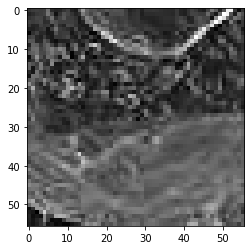

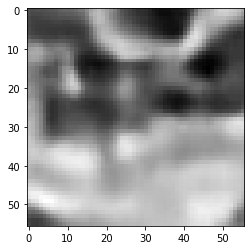

41.22121408581734

 next


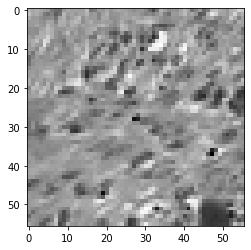

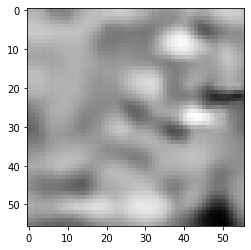

33.07594075798988

 next


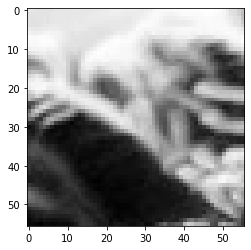

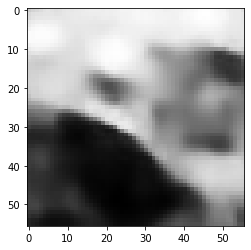

113.75362202525139

 next


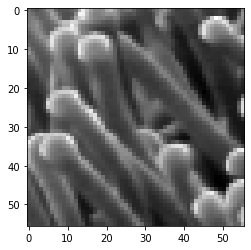

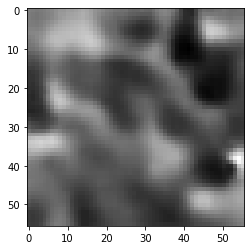

32.806835398077965

 next


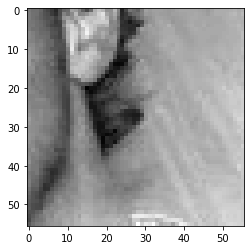

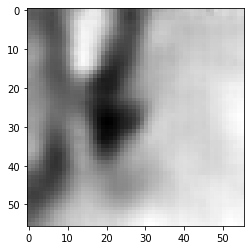

18.41581631451845

 next


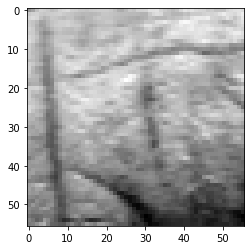

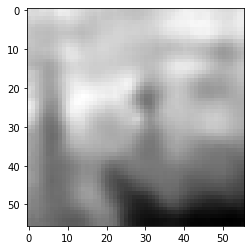

28.972689136862755

 next


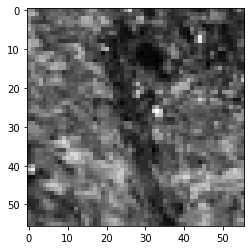

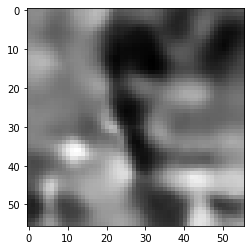

47.83833101391792

 next


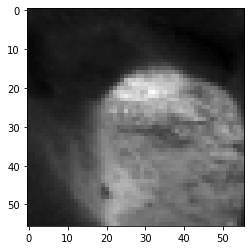

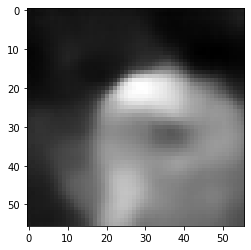

50.505191311240196

 next


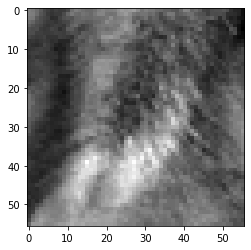

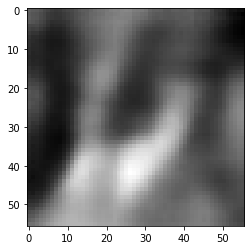

21.793901547789574

 next


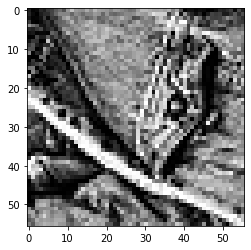

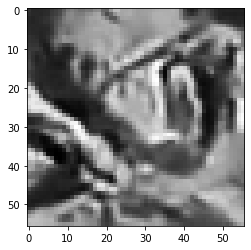

90.35678029060364

 next


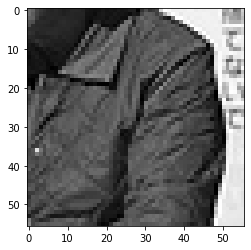

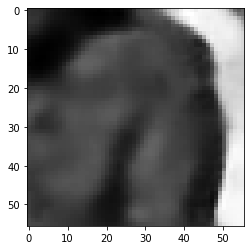

82.33622387051582

 next


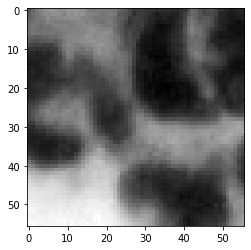

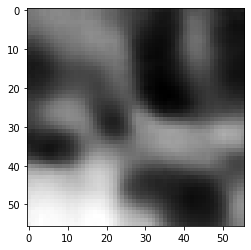

37.68285535275936

 next


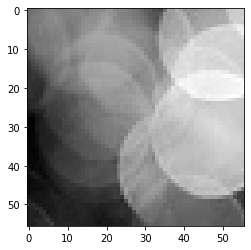

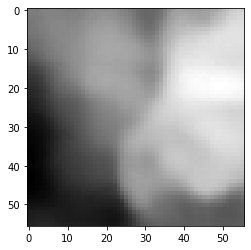

76.29733711481094

 next


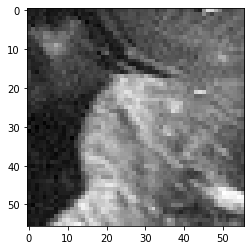

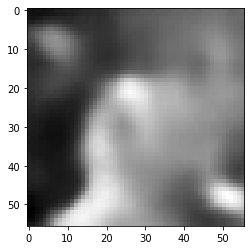

29.66074861586094

 next


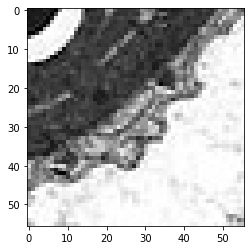

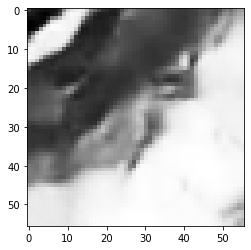

100.15528410673141

 next


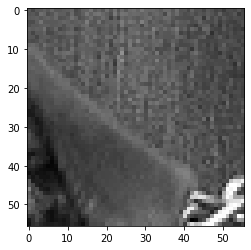

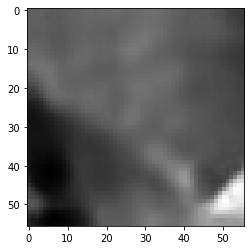

36.30563825368881

 next


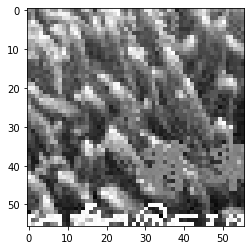

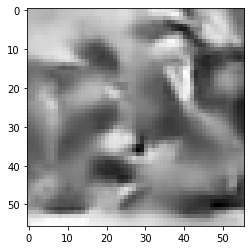

58.67610566318035

 next


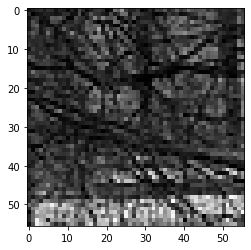

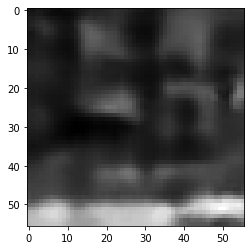

54.45135176181793

 next


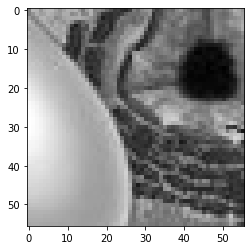

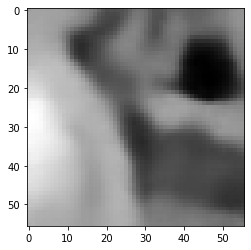

71.88881367444992

 next


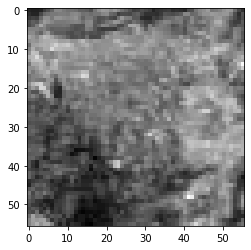

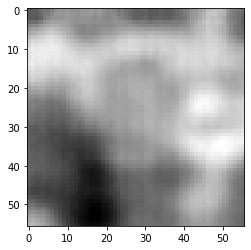

13.996177520602942

 next


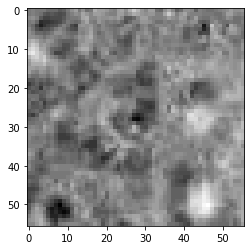

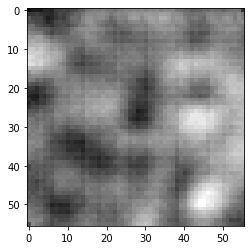

5.159764979034662

 next


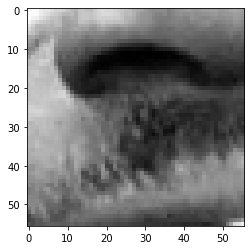

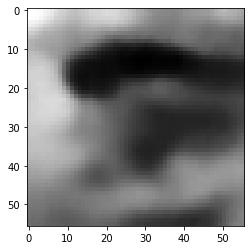

50.43280519545078

 next


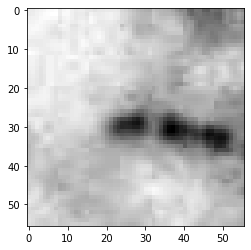

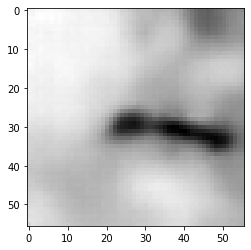

26.382183842360973

 next


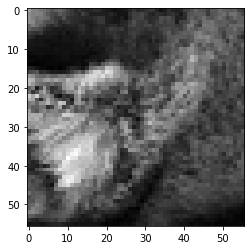

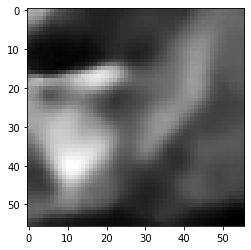

42.037775069475174

 next


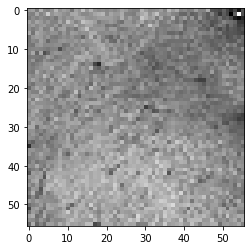

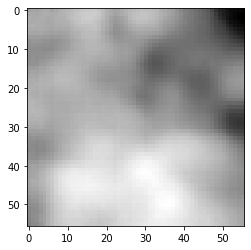

30.499954484403133

 next


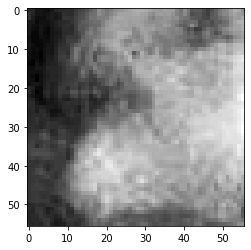

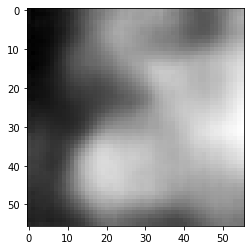

22.054151482880116

 next


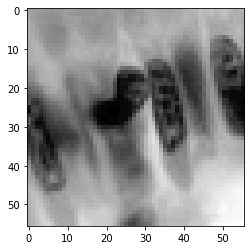

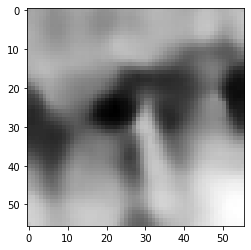

59.56128716468811

 next


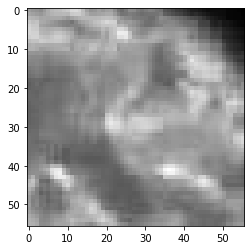

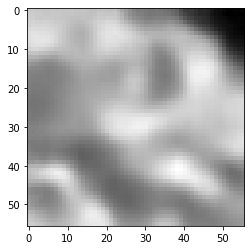

30.098798610270023

 next


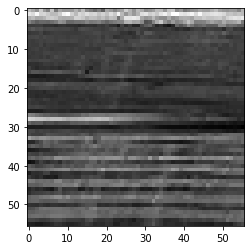

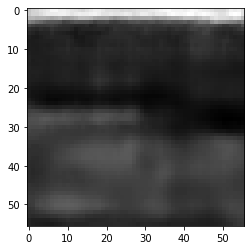

40.42988374829292

 next


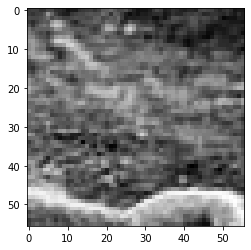

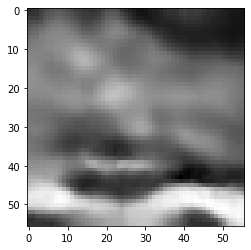

39.970230013132095

 next


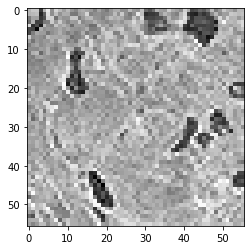

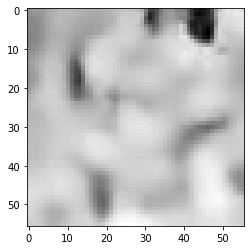

42.72156357765198

 next


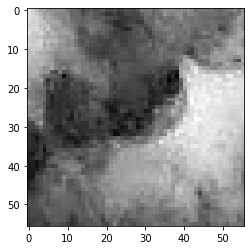

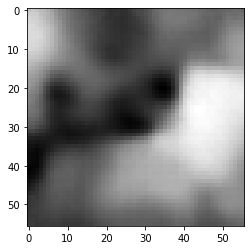

30.171106830239296

 next


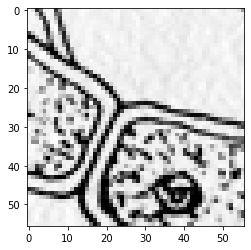

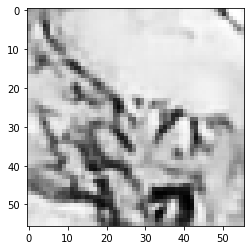

96.24657064676285

 next


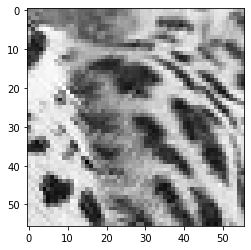

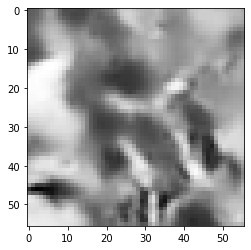

68.37812885642052

 next


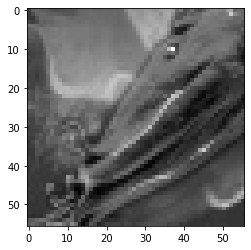

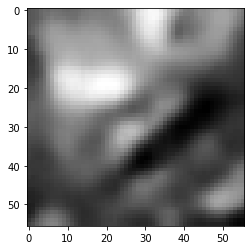

34.77565035223961

 next


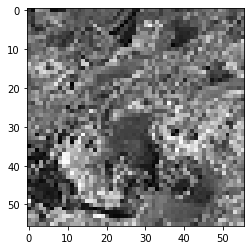

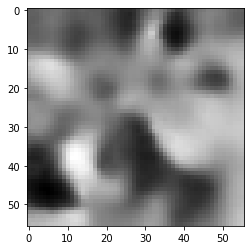

55.429062098264694

 next


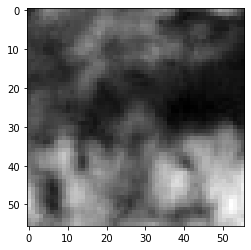

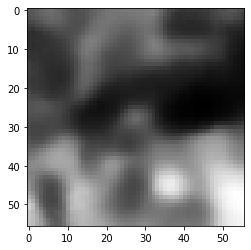

47.442133873701096

 next


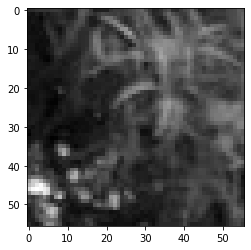

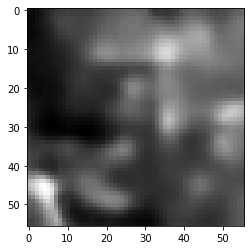

29.351291321218014

 next


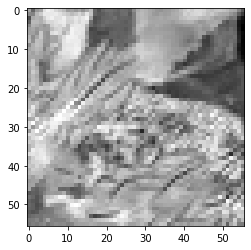

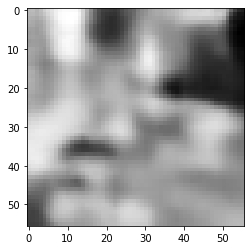

52.24612109363079

 next


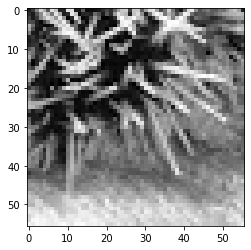

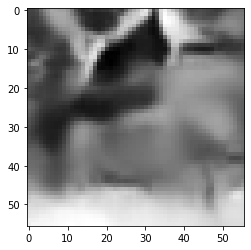

77.66321942210197

 next


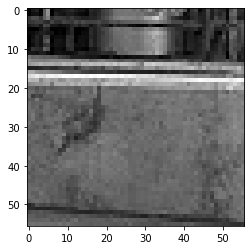

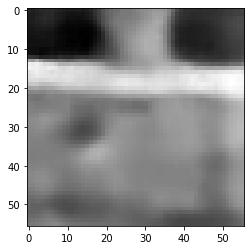

44.813632518053055

 next


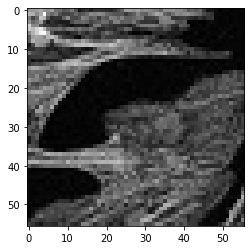

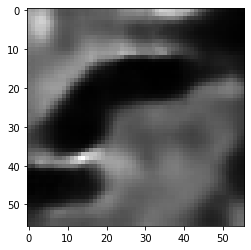

32.35700033605099

 next


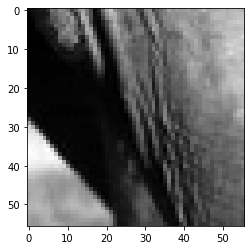

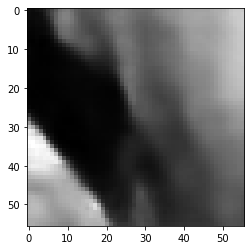

59.41898100078106

 next


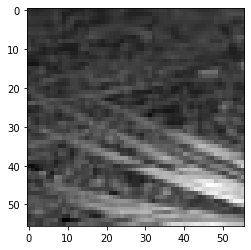

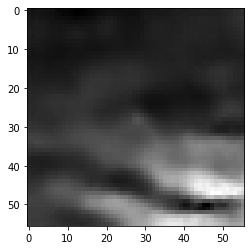

33.00593711435795

 next


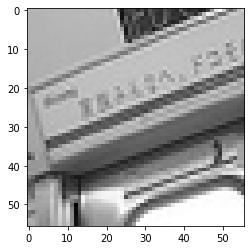

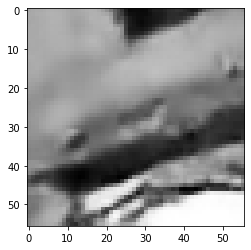

72.00503423810005

 next


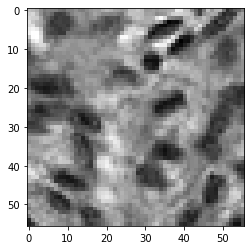

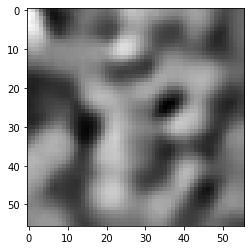

41.53970919549465

 next


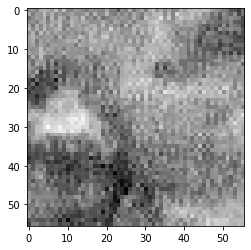

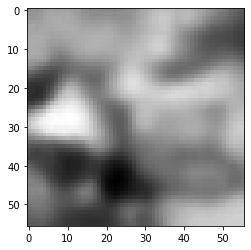

49.76757109165192

 next


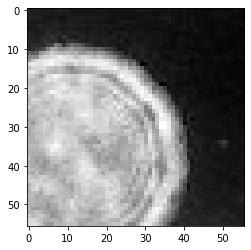

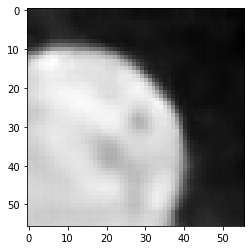

66.36755034327507

 next


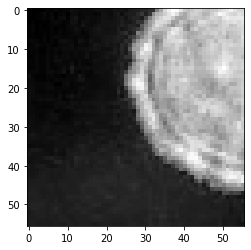

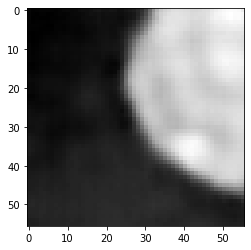

58.78611735999584

 next


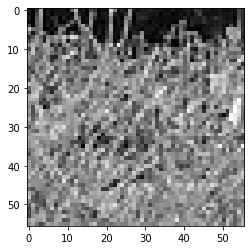

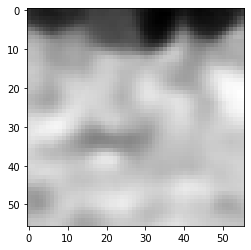

60.6050493568182

 next


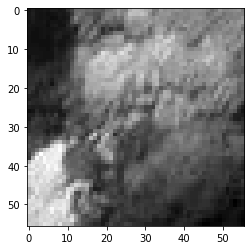

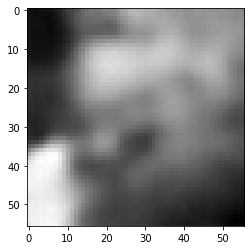

28.597799353301525

 next


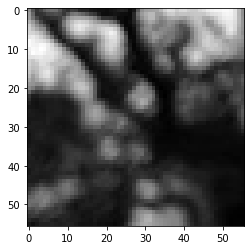

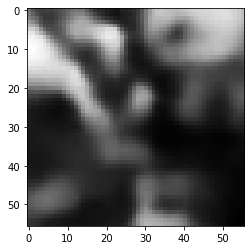

60.5951052904129

 next


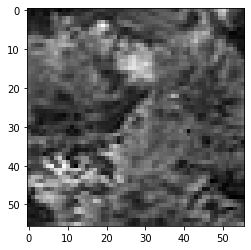

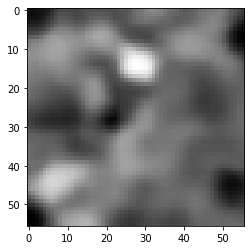

31.005053780972958

 next


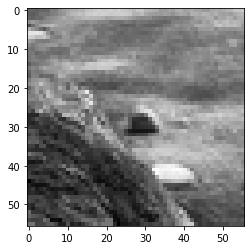

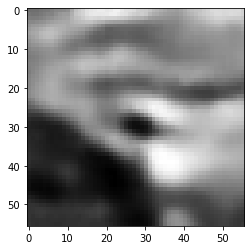

54.89536553621292

 next


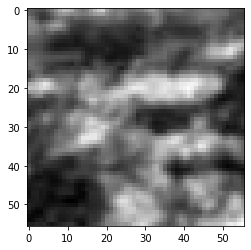

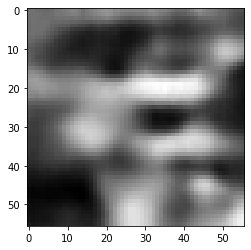

31.558775268495083

 next


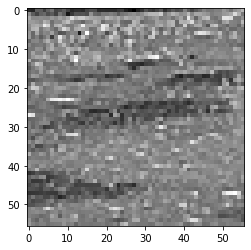

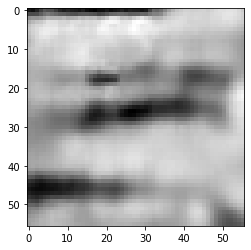

34.1617438942194

 next


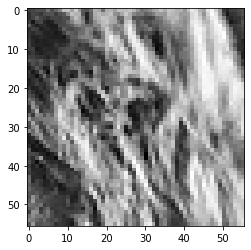

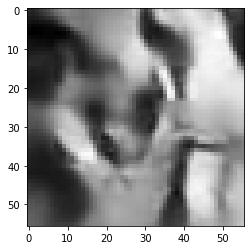

75.05047962069511

 next


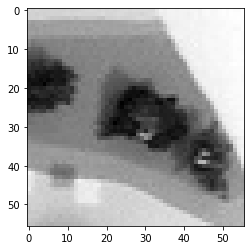

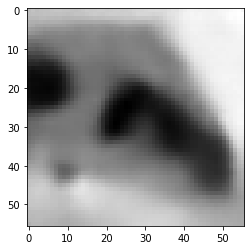

59.67493526637554

 next


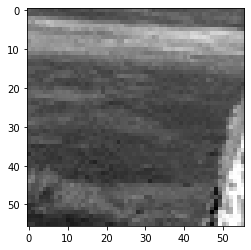

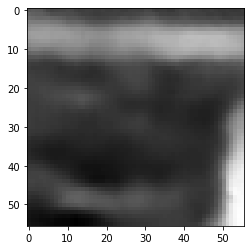

50.80126382410526

 next


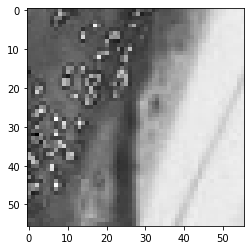

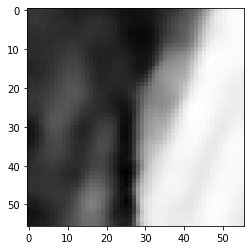

76.52254343032837

 next


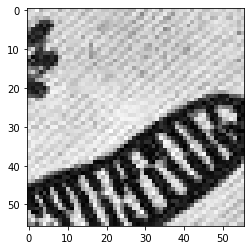

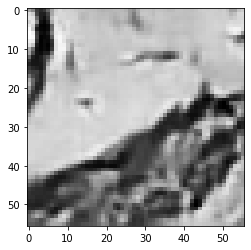

93.43640863895416

 next


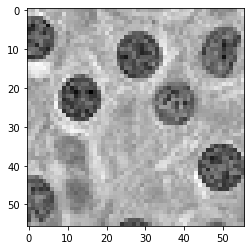

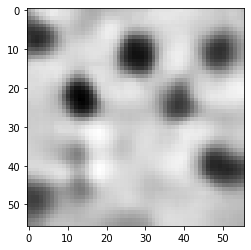

50.52762910723686

 next


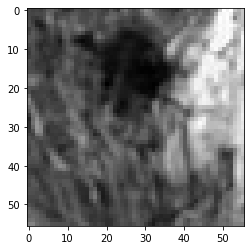

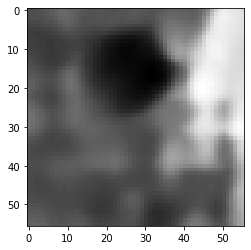

68.98368716239929

 next


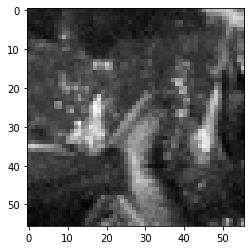

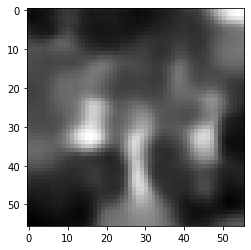

34.57190528512001

 next


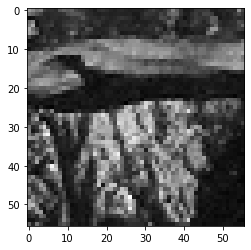

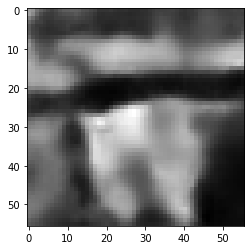

60.202616751194

 next


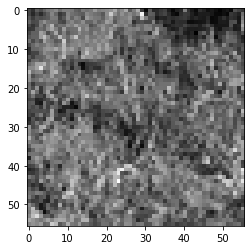

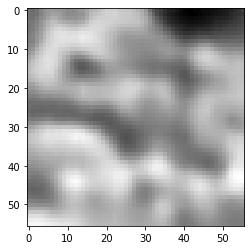

32.14774176478386

 next


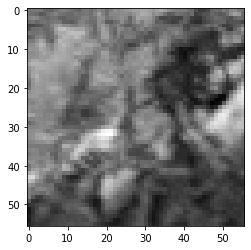

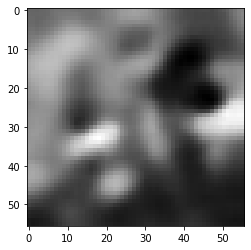

40.52687354385853

 next


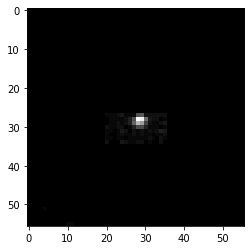

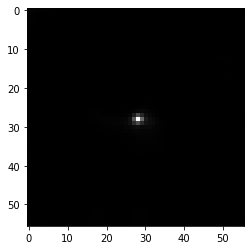

1.6185084264725447

 next


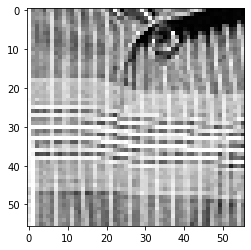

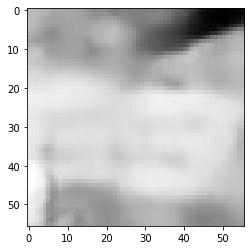

72.08025500178337

 next


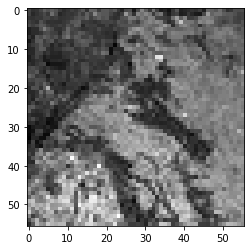

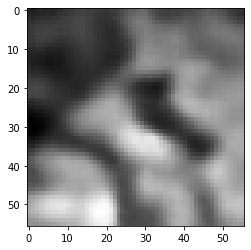

31.053972356021404

 next


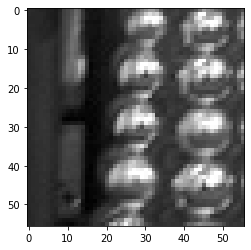

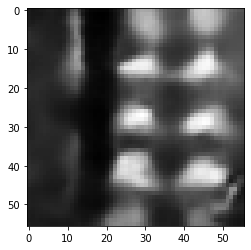

74.99732807278633

 next


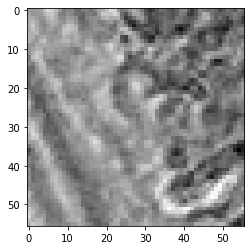

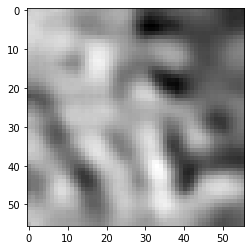

31.07345011085272

 next


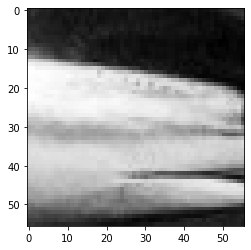

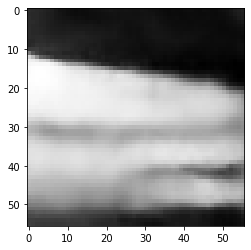

100.2822732925415

 next


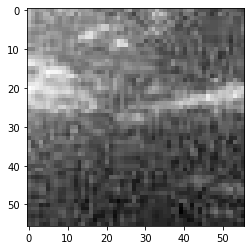

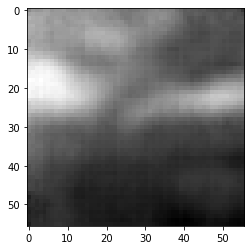

11.27729231491685

 next


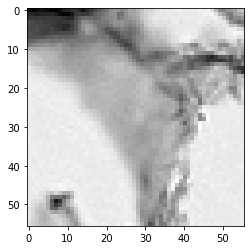

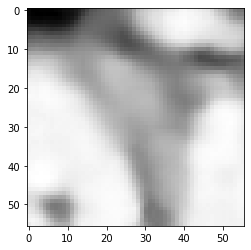

60.566546022892

 next


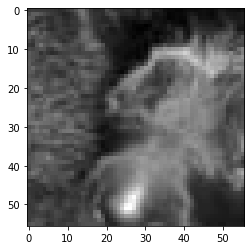

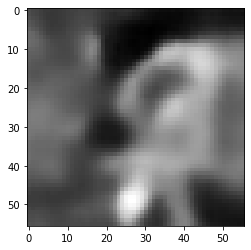

46.86772249639034

 next


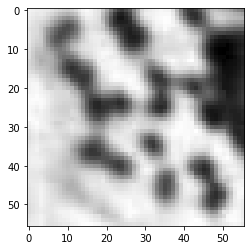

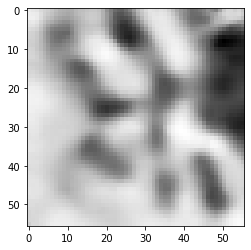

50.051054880023

 next


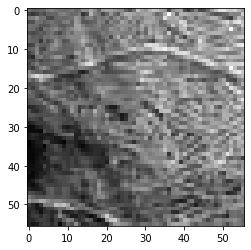

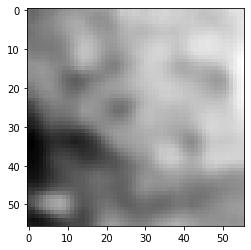

38.05485159158707

 next


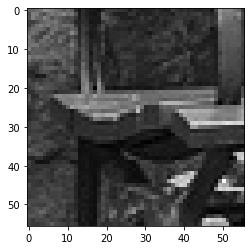

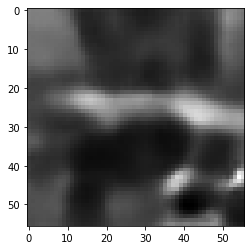

36.60782463848591

 next


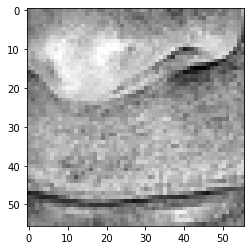

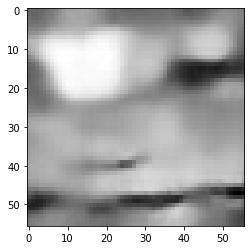

48.0554323643446

 next


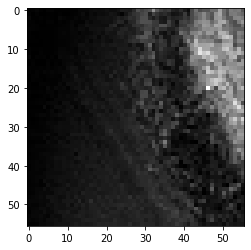

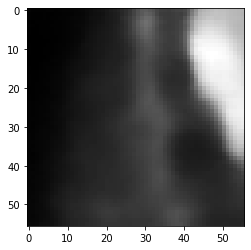

49.64196503162384

 next


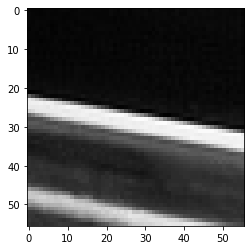

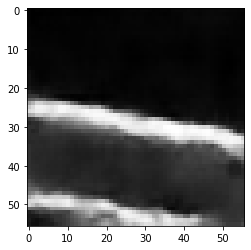

92.81176015734673

 next


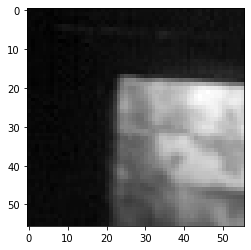

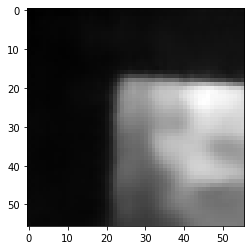

68.45442116260529

 next


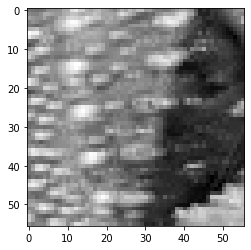

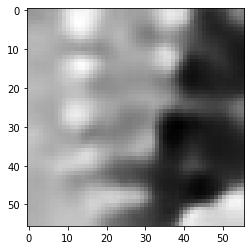

56.18542291224003

 next


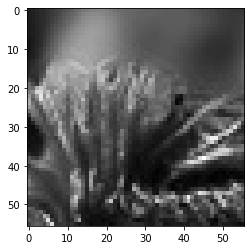

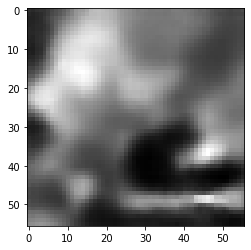

34.72349055111408

 next


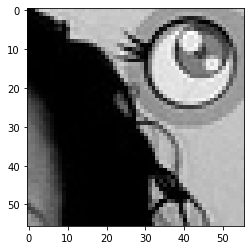

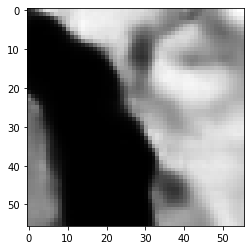

89.46187511086464

 next


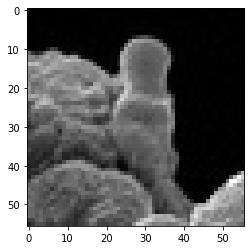

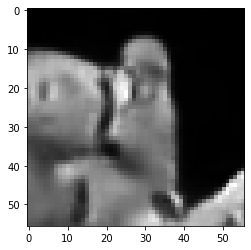

84.80666890740395

 next


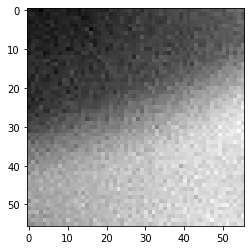

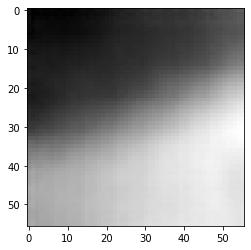

22.43855595588684

 next


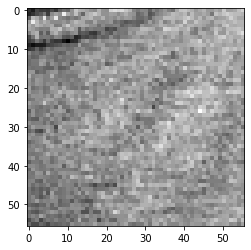

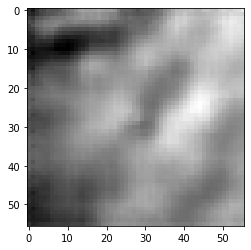

10.077819228172302

 next


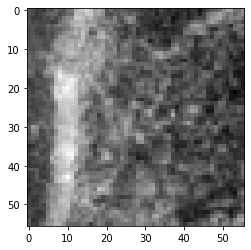

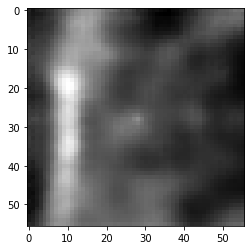

13.9083955809474

 next


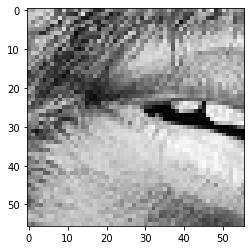

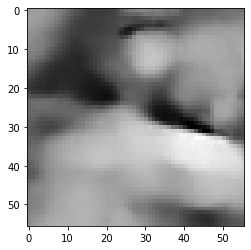

66.98153659701347

 next


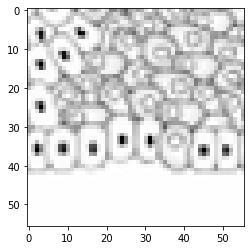

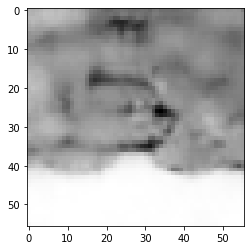

47.28593945503235

 next


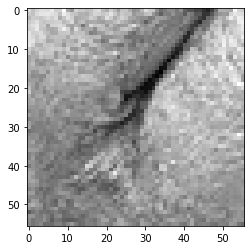

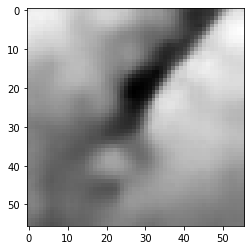

42.26295478641987

 next


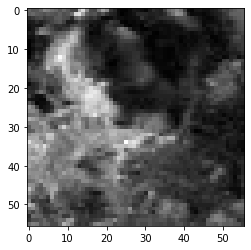

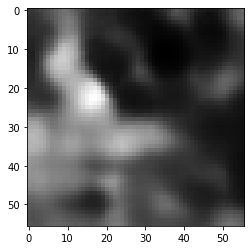

40.156294628977776

 next


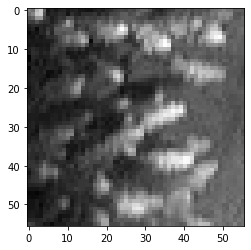

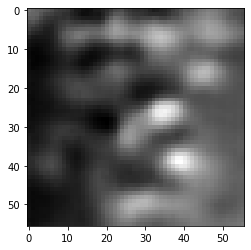

22.22640383988619

 next


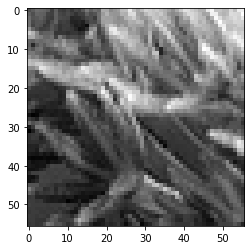

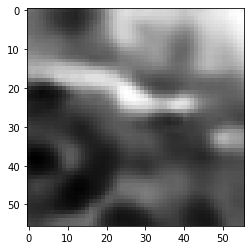

65.97073763608932

 next


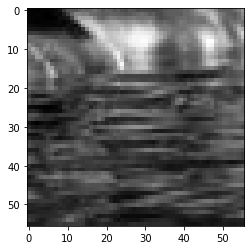

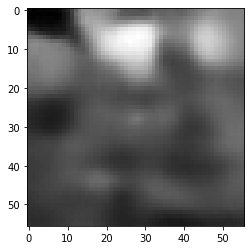

41.668332293629646

 next


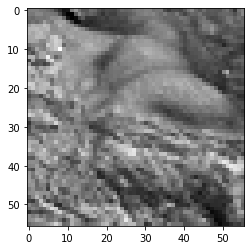

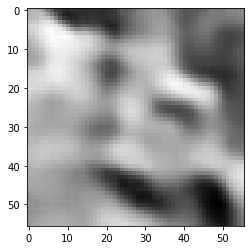

32.8705807775259

 next


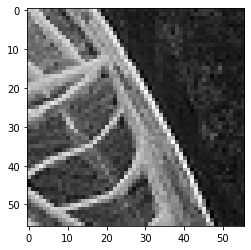

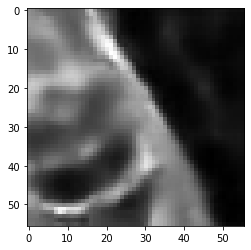

66.47092759609222

 next


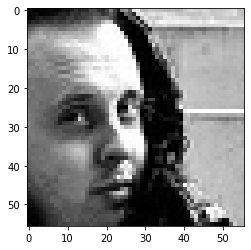

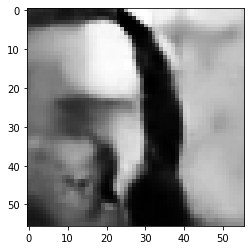

111.78898304700851

 next
0.19552739715203643


In [43]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [16]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())

# history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

# model_version = "0.0.0.5"
# vae.save_weights(base_dir + '/vae_' + model_version + '.h5')
